# Hotel Bookings

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Studente: Alessandro Lombardini  
alessandr.lombardin3@unibo.it


In [147]:
# Setup librerie
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

## Caso di studio

- Data una prenotazione di un cliente presso un hotel, si vuole valutare se questa verrà cancellata

- Da ciascuna prenotazione possono essere estratte delle caratteristiche

  - numero di adulti, giorno di arrivo, numero di posti auto richiesti, ...
  
- Vogliamo addestrare un modello a classificare ciascuna prenotazione sulla base di queste caratteristiche

- Utilizziamo [Hotel booking demand](https://www.kaggle.com/jessemostipak/hotel-booking-demand), in cui ogni osservazione contiene le caratteristiche estratte da una prenotazione

- Con `read_csv` possiamo importare il dataset direttamente in un frame pandas dato il suo URL

In [148]:
HBD_URL = "https://bitbucket.org/alessandrolombardini/hotel-bookings/raw/d5130f7e47e3e943886c1ab5266197202e6fe9af/hotel_bookings.csv"
hbd_complete = pd.read_csv(HBD_URL)

In [149]:
hbd_complete.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02


- `Hotel booking demand` prevede al suo interno due dataset, uno per _Resort Hotel_ e uno per _City Hotel_
    - Entrambi i dataset condividono la stessa struttura
    - Entrambi comprendono prenotazioni effettuate dal 1 Luglio 2015 al 31 Agosto 2017
    
- Poichè questi sono dati reali, tutti i dati personali dei clienti sono stati eliminati oppore sostiuiti con identificativi anonimi


- Il dataset presenta le seguenti dimensioni...

In [150]:
print(hbd_complete.shape[0], "istanze")
print(hbd_complete.shape[1], "variabili\n")
print(hbd_complete[hbd_complete["hotel"]=="City Hotel"].shape[0], "istanze di City Hotel")
print(hbd_complete[hbd_complete["hotel"]=="Resort Hotel"].shape[0], "istanze di Resort Hotel")

119390 istanze
32 variabili

79330 istanze di City Hotel
40060 istanze di Resort Hotel


- Il nostro obiettivo è realizzare un modello di classificazione per la struttura _City Hotel_


- Si tratta di classificazione binaria, ovvero con due possibili classi
    - La colonna `is_canceled` indica la classificazione delle prenotazioni 
        - 0 = non cancellata
        - 1 = cancellata
    - Le altre 31 colonne corrispondono alle altre variabili estratte dalla prenotazione


### Lista delle variabili

- `hotel`: hotel prenotato dal cliente (H1 = Resort Hotel o H2 = City Hotel)
- `lead_time`: numero di giorni che intercorrono dal giorno di prenotazione al giorno di arrivo in hotel del cliente
- `arrival_date_year`: anno di arrivo del cliente in hotel
- `arrival_date_month`: mese di arrivo del cliente in hotel
- `arrival_date_week_number`: numero della settimana dell'anno di arrivo del cliente in hotel
- `arrival_date_day_of_month`: numero del giorno del mese di arrivo del cliente in hotel
- `stays_in_weekend_nights`: numero di notti di finesettimana (Sabato e Domenica) prenotate del cliente
- `stays_in_week_nights`:  numero di notti non di finesettimana (da Lunedi a Venerdi) prenotate del cliente
- `adults`: numero di adulti 
- `children`: numero di bambini 
- `babies`: numero di neonati
- `meal`: pacchetto pasti richiesto dal cliente
    - Undefined/SC – nessuno pacchetto
    - BB – Bed & Breakfast 
    - HB – Mezza pensione (colazione ed un altro pasto – solitamente cena); 
    - FB – Pensione completa (colazione, pranzo e cena)
- `country`: stato di provenienza
- `market_segment`: segmento di mercato associato alla prenotazione (utile per raggruppare le prenotazioni in gruppi, al fine di adottare stategie di marketing adeguate)
- `distribution_channel`: canale per tramite del quale il cliente ha effettuato la prenotazione (TA/TO: il cliente si è appoggiato ad un agente di viaggio, Direct: la prenotazione è stata fatta dal cliente direttamente, ed altri)
- `is_repeated_guest`: indica se la prenotazione è fatta da un cliente che aveva già prenotato in passato
    - 1: Si, aveva già prenotato
    - 0: No, non aveva mai prenotato
- `previous_cancellations`: numero di prenotazioni cancellate in passato dal cliente
- `previous_bookings_not_canceled`: numero di prenotazioni effettuate in passato dal cliente e non cancellate
- `reserved_room_type`: codice del tipo di stanza richiesta dal cliente
- `assigned_room_type`: codice del tipo di stanza assegnata alla prenotazione. A volte vengono assegnate stanze diverse da quelle riservate per motivi legati all'Hotel (es. overbooking) o per richiesta del cliente. 
- `booking_changes`: numero di cambiamenti apportati alla prenotazione fino al momento del Check-In o della cancellazione
- `deposit_type`: indica se il cliente ha effettuato un deposito per garantirsi la prenotazione
    - No Deposit: nessun deposito è stato fatto
    - Non Refund: è stato pagato l'intero importo del soggiorno
    - Refundable: è stata pagata solo una parte dell'importo dell'intero soggiorno
- `agent`: ID dell'agente di viaggio che ha effettuato la prenotazione
- `company`: ID della compagnia che ha effettuato la prenotazione o che ha pagato la prenotazione. 
- `days_in_waiting_list`: numero di giorni in cui la prenotazione è rimasta in lista di attesa prima di essere confermata al cliente
- `customer_type`: tipologia di prenotazione
    - Contract: la prenotazione è associata ad un contratto
    - Group: la prenotazione è associata ad un gruppo
    - Transient: la prenotazione non è parte ne di un gruppo ne di un contratto, e non è associata ad altre prenotazione Transient 
    - Transient-party: la prenotazione è Transient ed è associata ad altre prenotazioni Transient (Transient è un termine utilizzato per indicare quelle prenotazioni effettuate da soggetti prevalentemente in movimento che effettuano brevi soggiorni in hotel, spesso last minute)
- `adr`: Avarage Daily Rate, definito come il costo del soggiorno diviso il numero di notti
- `required_car_parking_spaces`: numero di spazi macchina richiesti dal cliente
- `total_of_special_requests`: numero di richieste speciali effettuate dal cliente
- `reservation_status`: ultimo stato registrato della prenotazione
    - Canceled: la prenotazione è stata cancellata dal cliente
    - Check-Out: il client ha effettuato il Check-In e la sua permanenza è terminata
    - No-Show: il cliente non ha effettuato il Check-In e ha informato l'hotel del motivo
- `reservation_status_date`: data dell'ultima modifica alla variabile `reservation_status` 
- **`is_canceled`**: indica se la prenotazione è stata cancellata o no
    - 0: Non cancellata
    - 1: Cancellata
    
    
    
- La variabile **is_canceled** indica la classificazione della prenotazione, vogliamo stabilire il valore di questa variabile in funzione delle altre

- Aumentiamo il limite di colonne che pandas di default ci consente di visualizzare

In [151]:
pd.options.display.max_columns = 32

In [152]:
hbd_complete.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02


## Preparazione dei dati

- Riportiamo lo spazio occupato in memoria dal dataset

In [153]:
hbd_complete.info(verbose=False, memory_usage="deep");

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Columns: 32 entries, hotel to reservation_status_date
dtypes: float64(4), int64(16), object(12)
memory usage: 105.7 MB


- Osserviamo che sono presenti molte variabili di tipo _object_
    - Il dataset così caricato occupa molto spazio, è quindi opportuno specificare che parte delle variabili _object_ devono essere gestite come categoriche
        - Tutte eccetto `reservation_status_date` in quanto presenta come valori delle date

In [154]:
object_variable = hbd_complete.dtypes[hbd_complete.dtypes == np.object].drop(["reservation_status_date"]).index
hbd_complete[object_variable] = hbd_complete[object_variable].astype("category")

- Verifichiamo la dimensione in memoria attuale

In [155]:
hbd_complete.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Columns: 32 entries, hotel to reservation_status_date
dtypes: category(11), float64(4), int64(16), object(1)
memory usage: 27.2 MB


- Lo spazio occupato in memoria si è circa dimezzato due volte



- Come accennato il nostro obiettivo è realizzare un modello di classificazione per una specificia struttura ospitante, la struttura _City Hotel_

    - Il dataset prevede istanze di due strutture: _Resort Hotel_ e _City Hotel_

In [156]:
hbd_complete["hotel"].unique()

[Resort Hotel, City Hotel]
Categories (2, object): [Resort Hotel, City Hotel]

- La preparazione dei dati viene effettuata sul dataset completo per poi rimuovere le istanze di _Resort Hotel_ al termine
    - Il dataset completo ci sarà utile in seguito
    
    
- Visualizziamo il numero di valori distinti per ciascuna feature

In [157]:
hbd_complete.nunique()

hotel                                2
is_canceled                          2
lead_time                          479
arrival_date_year                    3
arrival_date_month                  12
arrival_date_week_number            53
arrival_date_day_of_month           31
stays_in_weekend_nights             17
stays_in_week_nights                35
adults                              14
children                             5
babies                               5
meal                                 5
country                            177
market_segment                       8
distribution_channel                 5
is_repeated_guest                    2
previous_cancellations              15
previous_bookings_not_canceled      73
reserved_room_type                  10
assigned_room_type                  12
booking_changes                     21
deposit_type                         3
agent                              333
company                            352
days_in_waiting_list     

- Tutte le feature presentano una variabilità adatta alla loro semantica


- La variabili temporali associate all' arrivo del cliente in hotel attualmente presenti possono essere sostituite con altre variabili che presentano maggiore correlazione con ciò che stiamo cercando di prevedere

- Le variabili attualmente in nostro possesso sono:
    - `arrival_date_year` 
    - `arrival_date_month` 
    - `arrival_date_week_number`
    - `arrival_date_day_of_month`

- Per prima cosa vogliamo aggiungere il giorno della settimana (Lunedi, Martedi, ...)

    - In questo contesto è infatti più rilevante il giorno della settimana piuttosto che il giorno del mese
        
        - Per farlo è necessario avere a nostra disposizione un dizionario che ci consenta di ottenere, dato il nome del mese, il suo indice (1. Gennaio, 2. Febbrario, ...)

In [158]:
import calendar
dict_month_convertion = dict((v,k) for k,v in enumerate(calendar.month_name))

- Mostriamo un esempio

In [159]:
hbd_complete["arrival_date_month"].head(1)

0    July
Name: arrival_date_month, dtype: category
Categories (12, object): [April, August, December, February, ..., May, November, October, September]

In [160]:
hbd_complete["arrival_date_month"].head(1).map(dict_month_convertion)

0    7
Name: arrival_date_month, dtype: category
Categories (12, int64): [4, 8, 12, 2, ..., 5, 11, 10, 9]

- Utilizziamo questo dizionario per ottenere una serie che mappa, con il metodo appena mostrato, la variabile `arrival_date_month`

In [161]:
arrival_date_month_number = hbd_complete["arrival_date_month"].map(dict_month_convertion)

- Definiamo una funzione che presa in input una data, una stringa nel formato _giorno mese anno_ , ci restituisca il nome del giorno 

In [162]:
import datetime 
  
def findDay(date): 
    day = datetime.datetime.strptime(date, '%d %m %Y').weekday() 
    return (calendar.day_name[day]) 

- Realizziamo la nuova variabile `arrival_date_day`
    - Anche essa categorica

In [163]:
arrival_date_day = []
for index, row in hbd_complete.iterrows():
    arrival_date_day.append(findDay("{0} {1} {2}".format(row["arrival_date_day_of_month"], arrival_date_month_number[index], row["arrival_date_year"])))

hbd_complete.insert(2, "arrival_date_day", arrival_date_day)
hbd_complete["arrival_date_day"] = hbd_complete["arrival_date_day"].astype("category")

- Eliminiamo la variabile `arrival_date_day_of_month`, ovvero il giorno del mese di arrivo in hotel

- Eliminiamo anche la variabile `arrival_date_year`, in quanto non particolarmente utile

In [164]:
hbd_complete.drop(inplace=True, axis=1, labels=['arrival_date_year', 'arrival_date_day_of_month'])

- La variabile `assigned_room_type` non è disponibile al momento della prenotazione, ma solo al momento del Check-In. Rappresenta la camera che viene assegnata al cliente al momento del suo arrivo in hotel, e non la camera prenotata. 
    - E' dunque rimossa

In [165]:
hbd_complete.drop(inplace=True, axis=1, labels=['assigned_room_type'])

- Osservando la descrizione delle variabili è possibile notare come vi sia una grossa affinità tra le variabili `is_canceled` e `reservation_status`

- I possibili valori di `reservation_status` sono...

In [166]:
hbd_complete["reservation_status"].unique()

[Check-Out, Canceled, No-Show]
Categories (3, object): [Check-Out, Canceled, No-Show]

- Il valore _Check-Out_ potrebbe corrispondere alla mancata cancellazione, mentre il valore _Canceled_ alla effettiva cancellazione. Anche il campo _No-Show_ potrebbe essere considerato come prenotazione cancellata.
    - Definiziamo un dizionario in cui mappiamo i valori di `reservation_status`
        - Check-Out come non cancellata (0)
        - No-Show come cancellata (1)
        - Canceled come cancellata (1)

In [167]:
mapping_reservation_status = {}
mapping_reservation_status['Check-Out'] = 0
mapping_reservation_status['No-Show'] = 1
mapping_reservation_status['Canceled'] = 1

- Mappiamo la variabile `reservation_status` con il dizionario creato

In [168]:
reservation_status_mapped = hbd_complete["reservation_status"].map(mapping_reservation_status)

- Verifichiamo se la serie ottenuta coincice con la variabile `is_canceled`. 

In [169]:
all(hbd_complete["is_canceled"] == reservation_status_mapped)

True

- La considerazione era corretta, le variabili `is_canceled` e `reservation_status` coincidono.
    - Il valore _Check-Out_ viene utilizzato quando la prenotazione non è stata cancellata
    - I valori _Canceled_ e _No-Shown_ vengono invece utilizzati quando la prenotazione è stata cancellata.


- Questa variabile va dunque rimossa in quanto coincide con la variabile da predire
    - Rimuoviamo anche `reservation_status_date`, in quanto inutile senza `reservation_status`

In [170]:
hbd_complete.drop(inplace=True, axis=1, labels=['reservation_status', 'reservation_status_date'])

- Verifichiamo la presenza del valore `nan` nelle istanze

In [171]:
hbd_complete.isnull().sum()

hotel                                  0
is_canceled                            0
arrival_date_day                       0
lead_time                              0
arrival_date_month                     0
arrival_date_week_number               0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_list                   0
customer_type   

- Il valore `nan` è presente nelle variabili: 
    - `children` 
    - `country`
    - `agent`
    - `company`
    
    
- Per le variabili `children` e `country` tale valore non è accettabile, per cui rimuovo quelle istanze 

In [172]:
hbd_complete.dropna(subset=["country", "children"], inplace=True)

- La variabile `company` è nulla in quasi tutte le istanze, mentre `agent` per una buona parte di esse. 

- Il valore nullo in questo caso è di nostro interesse in quanto implica che per quella prenotazione non è presente, rispettivamente, una company e/o un agent
    - Sostituiamo i valori di queste due variabili con 0 e 1
        - 0 se il valore è `nan`
        - 1 altrimenti
    - In questo modo manteniamo l'informazione relativa alla presenta (o assenza) di un agent e/o di una company in una prenotazione
        - Non è di particolare interesse sapere esattamente chi sia il soggetto interessato

In [173]:
hbd_complete.loc[hbd_complete["agent"].isnull(), "agent"] = 0 
hbd_complete.loc[hbd_complete["agent"] != 0, "agent"] = 1
hbd_complete.loc[hbd_complete["company"].isnull(), "company"] = 0 
hbd_complete.loc[hbd_complete["company"] != 0, "company"] = 1

- Un' alternativa era quella di selezionare solo parte dei possibili valori di `agent` e `company` (i più frequenti) e considerare questa variabile come categorica. Ai valori più frequenti ottenuti ne andrebbero aggiunti due: _Nessuno_ per sostituire tutti i valori `nan` e _Altro_ , per sostituire tutti i valori diversi da `nan` non presenti fra i valori più frequenti.
    - Si è optato di non seguire questa strada

- Non sono più presenti valori  `nan`

In [174]:
hbd_complete.isnull().sum()

hotel                             0
is_canceled                       0
arrival_date_day                  0
lead_time                         0
arrival_date_month                0
arrival_date_week_number          0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

- Verifichiamo la tipologia delle variabili in nostro possesso

In [175]:
hbd_complete.dtypes

hotel                             category
is_canceled                          int64
arrival_date_day                  category
lead_time                            int64
arrival_date_month                category
arrival_date_week_number             int64
stays_in_weekend_nights              int64
stays_in_week_nights                 int64
adults                               int64
children                           float64
babies                               int64
meal                              category
country                           category
market_segment                    category
distribution_channel              category
is_repeated_guest                    int64
previous_cancellations               int64
previous_bookings_not_canceled       int64
reserved_room_type                category
booking_changes                      int64
deposit_type                      category
agent                              float64
company                            float64
days_in_wai

- Converto ad intero le variabili
    - `children`
    - `agent`
    - `company`

In [176]:
hbd_complete["agent"] = hbd_complete["agent"].astype("int64")
hbd_complete["company"] = hbd_complete["company"].astype("int64")
hbd_complete["children"] = hbd_complete["children"].astype("int64")

In [177]:
print("children: ", hbd_complete["children"].dtype)
print("agent: ", hbd_complete["children"].dtype)
print("company: ", hbd_complete["children"].dtype)

children:  int64
agent:  int64
company:  int64


- Abbiamo terminato la preparazione dei dati
    - Viene ora creato un nuovo dataframe senza le istanze di _Resort Hotel_

In [178]:
hbd = hbd_complete[hbd_complete["hotel"] == "City Hotel"].copy()
hbd["hotel"].unique()

[City Hotel]
Categories (1, object): [City Hotel]

- Il dataset ora presenta...

In [179]:
print(hbd.shape[0], "istanze")

79302 istanze


- La variabile `hotel` è diventata inutile, è quindi rimossa

In [180]:
hbd.drop(inplace=True, axis=1, labels=['hotel'])

## Analisi esplorativa

- Visualizziamo le statistiche principali (media, dev, standard, ...) delle variabili

In [181]:
hbd.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,79302.0,0.417089,0.493081,0.0,0.0,0.0,1.0,1.0
lead_time,79302.0,109.740183,110.953223,0.0,23.0,74.0,163.0,629.0
arrival_date_week_number,79302.0,27.173564,13.397803,1.0,17.0,27.0,38.0,53.0
stays_in_weekend_nights,79302.0,0.795339,0.884985,0.0,0.0,1.0,2.0,16.0
stays_in_week_nights,79302.0,2.182896,1.456096,0.0,1.0,2.0,3.0,41.0
adults,79302.0,1.851126,0.509013,0.0,2.0,2.0,2.0,4.0
children,79302.0,0.091397,0.372230,0.0,0.0,0.0,0.0,3.0
babies,79302.0,0.004943,0.084338,0.0,0.0,0.0,0.0,10.0
is_repeated_guest,79302.0,0.025624,0.158010,0.0,0.0,0.0,0.0,1.0
previous_cancellations,79302.0,0.079771,0.415543,0.0,0.0,0.0,0.0,21.0


- Tutte le variabili presentano come minimo il valore (~) 0

- I valori non presentano la stessa scala, la standardizzazione potrà quindi essere certamente utile

- Alcune variabili mostrano un valore di massimo che in relazione alla loro semantica pare poco sensato
    - Visualizziamo il box plot di queste variabili

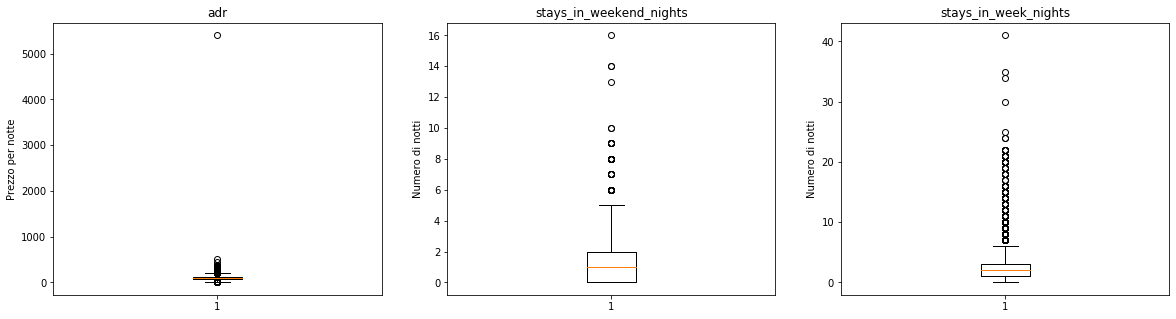

In [182]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.title('adr')
plt.boxplot(hbd['adr'])
plt.ylabel('Prezzo per notte')

plt.subplot(1, 3, 2)
plt.title('stays_in_weekend_nights')
plt.boxplot(hbd['stays_in_weekend_nights'])
plt.ylabel('Numero di notti')

plt.subplot(1, 3, 3)
plt.title('stays_in_week_nights')
plt.boxplot(hbd['stays_in_week_nights'])
plt.ylabel('Numero di notti')

plt.show()

- Possiamo notare alcuni outliers in tutte e tre le variabili
    - Il valore di massimo della variabile `adr` è estremamente lontanto dalla media
        - Viene rimosso in quanto potrebbe potenzialmente compromette i grafici dell'analisi esplorativa e alterare il modello 
    

In [183]:
hbd = hbd[hbd["adr"] != hbd["adr"].max()]

- In un problema di classificazione è utile visualizzare quanto le variabili predittive siano correlate con la classe da predire

- Per iniziare calcoliamo la correlazione Pearson tra tutte le coppie di features
   

In [184]:
hbd.corr().style.background_gradient(cmap='Spectral').set_precision(2)

,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,1,0.31,0.0013,-0.0071,0.049,0.053,-0.027,-0.03,-0.066,0.17,-0.053,-0.15,0.066,-0.092,0.061,-0.015,-0.13,-0.29
lead_time,0.31,1,0.13,-0.024,0.058,0.12,-0.054,-0.03,-0.11,0.12,-0.065,-0.031,0.19,-0.15,0.19,-0.15,-0.078,-0.13
arrival_date_week_number,0.0013,0.13,1,-0.00096,-0.0088,0.007,-0.0012,0.0055,0.0028,0.037,-0.012,0.0026,0.034,-0.031,0.018,0.021,-0.0038,0.016
stays_in_weekend_nights,-0.0071,-0.024,-0.00096,1,0.22,0.082,0.037,0.0065,-0.081,-0.039,-0.028,0.046,0.092,-0.089,-0.056,0.042,-0.024,0.069
stays_in_week_nights,0.049,0.058,-0.0088,0.22,1,0.088,0.037,0.0055,-0.094,-0.051,-0.041,0.08,0.1,-0.085,0.016,0.065,-0.038,0.064
adults,0.053,0.12,0.007,0.082,0.088,1,-0.0059,0.012,-0.17,-0.038,-0.11,-0.088,0.24,-0.27,-0.0078,0.29,0.011,0.16
children,-0.027,-0.054,-0.0012,0.037,0.037,-0.0059,1,0.024,-0.029,-0.044,-0.017,0.047,0.031,-0.047,-0.036,0.35,0.055,0.11
babies,-0.03,-0.03,0.0055,0.0065,0.0055,0.012,0.024,1,-0.0019,-0.0087,-0.0033,0.066,-0.014,-0.0087,-0.0091,0.015,0.02,0.072
is_repeated_guest,-0.066,-0.11,0.0028,-0.081,-0.094,-0.17,-0.029,-0.0019,1,0.27,0.45,0.014,-0.29,0.4,-0.024,-0.17,0.093,0.018
previous_cancellations,0.17,0.12,0.037,-0.039,-0.051,-0.038,-0.044,-0.0087,0.27,1,0.39,-0.04,-0.047,0.076,0.021,-0.14,-0.0034,-0.077


- A noi interessa particolamente la prima colonna, ovvero la relazione che intercorre tra la variabile dipendendente e tutte le altre
    - Prendiamo questi valori in valore assoluto e in ordine decrescente

In [185]:
cancel_corr = hbd.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.309369
total_of_special_requests         0.293807
previous_cancellations            0.166758
booking_changes                   0.149448
required_car_parking_spaces       0.133070
company                           0.092296
agent                             0.066481
is_repeated_guest                 0.065795
days_in_waiting_list              0.061039
adults                            0.053412
previous_bookings_not_canceled    0.053117
stays_in_week_nights              0.048691
babies                            0.030171
children                          0.027002
adr                               0.014641
stays_in_weekend_nights           0.007085
arrival_date_week_number          0.001331
Name: is_canceled, dtype: float64

- Apprendiamo che le variabili numeriche più correlate con la variabile dipendente sono:
    - `lead_time`
    - `total_of_special_requests`
    - `required_car_parking_spaces`
    - `previous_cancellations`
    - `booking_changes`

- Visualizziamo anche i valori più alti fra tutti quelli ottenuti (sempre in valore assoluto e sempre in ordine decrescente) 
    - Sono indice di collinearità, è quindi opportuno tenerne conto
    - La matrice con i valori di correlazione è simmetrica, estraiamo dunque solo metà di essa

In [186]:
(hbd.corr().abs().where(np.triu(np.ones(cancel_corr.abs().shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False)
                 .head(10))

agent                           company                           0.643897
is_repeated_guest               previous_bookings_not_canceled    0.451963
                                company                           0.395515
previous_cancellations          previous_bookings_not_canceled    0.392139
children                        adr                               0.346216
is_canceled                     lead_time                         0.309369
previous_bookings_not_canceled  company                           0.304077
is_canceled                     total_of_special_requests         0.293807
is_repeated_guest               agent                             0.291368
adults                          adr                               0.290379
dtype: float64

- Possiamo per esempio notare che...

In [187]:
hbd.groupby(['is_repeated_guest','previous_bookings_not_canceled']).size().unstack().fillna(0)[[0, 1, 2, 3, 4, 5]]

previous_bookings_not_canceled,0,1,2,3,4,5
is_repeated_guest,,,,,,
0,77096.0,136.0,5.0,2.0,6.0,0.0
1,617.0,433.0,187.0,127.0,96.0,90.0


- La forte correlazione tra le variabili `is_repeated_guest` e `previous_bookings_not_canceled` è dovuta al fatto che quando un cliente è nuovo (la gran parte dei casi) ovviamente non ha a suo nome nessuna prenotazione cancellata


- Oppure che...


In [188]:
hbd.groupby(['previous_cancellations', 'previous_bookings_not_canceled']).size().unstack().fillna(0)[[0,1,2]].head(3)

previous_bookings_not_canceled,0,1,2
previous_cancellations,,,
0,72759.0,526.0,173.0
1,4936.0,25.0,16.0
2,4.0,5.0,2.0


- L'osservazione enunciata sopra può essere applicata anche alle variabili `previous_cancellations` e `previous_bookings_not_canceled`
    - quando un cliente è nuovo non ha a suo nome nessuna prenotazione, sia essa cancellata o non cancellata
    
    
- Visualizziamo i grafici a dispersione delle variabili che tenuto conto del dominio analizzato possono essere ritenute le più interessanti

C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


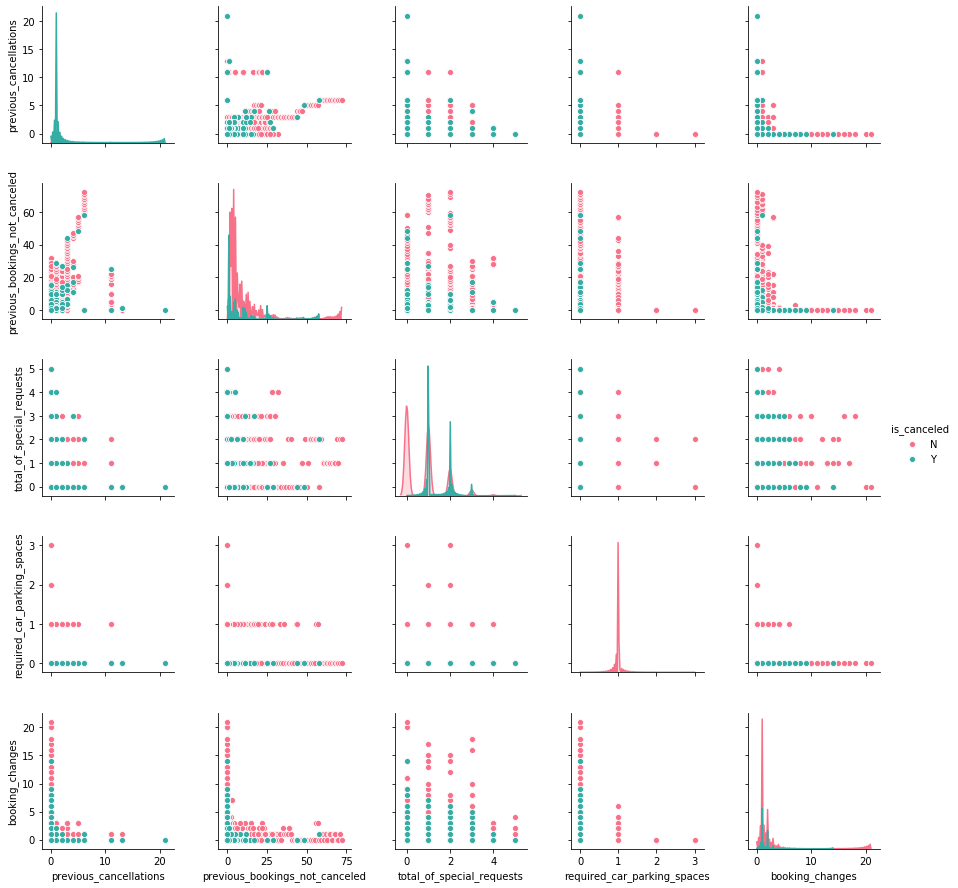

In [189]:
import seaborn as sns
hbd_temp = hbd.copy()
hbd_temp["is_canceled"] = hbd_temp["is_canceled"].map(lambda value: "N" if value is 0 else "Y")
sns.pairplot(hbd_temp[['previous_cancellations', 'previous_bookings_not_canceled', 'total_of_special_requests', 'required_car_parking_spaces', 'booking_changes', 'is_canceled']], hue="is_canceled", palette="husl")

- Osserviamo che...
    - Quando la variabile `required_car_parking_spaces` assume valore maggiore o uguale a 1 nessuna prenotazione risulta essere cancellata
    
    - Quando vengono effettuate molte modifiche alla prenotazione è molto probabile che il cliente non abbia mai effettuato ne cancellazioni ne altro.
        - Possiamo supporre che quando vengono effettuate molte modifiche alla prenotazione questa provenga da un nuovo cliente
    
    - Le prenotazioni che prevedono molte modifiche in genere non vengono cancellate
    
    - All'aumentare del numero di prenotazioni non cancellate si dimostrano meno presenti prenotazioni cancellate 
    
    
    

- Analiziamo ora alcune variabili più nel dettaglio, iniziando dalla variabile dipendente

### Variabile `is_canceled`

- Stampiamo il numero di valori `0` e `1` della variabile `is_canceled`, e rappresentiamo la distribuzione di tali valori in un diagramma a torta

In [190]:
hbd["is_canceled"].value_counts()

0    46226
1    33075
Name: is_canceled, dtype: int64

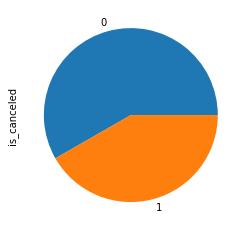

In [191]:
hbd["is_canceled"].value_counts().plot.pie();

- La suddivisione delle istanze nelle classi è abbastanza bilanciata, non siamo dunque soggetti ai problemi che un forte sblinciamento comporterebbe.

- Analizziamo ora le variabili che hanno ottenuto il maggiore valore di correlazione con la variabile dipendende, ovvero:
    - `lead_time`
    - `total_of_special_requests`
    - `required_car_parking_spaces`
    - `previous_cancellations`
    - `booking_changes`

### Variabile `lead_time`

- Visualizziamo la percentuale di cancellazione per i valori di `lead_time`

Text(0, 0.5, 'Cancelations [%]')

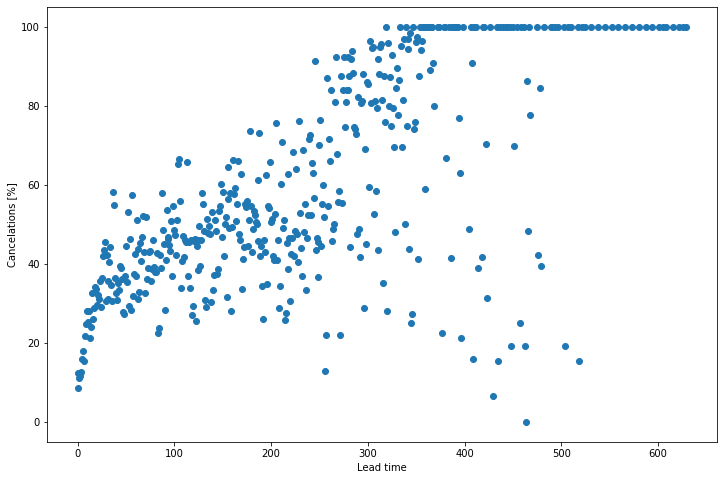

In [192]:
plt.figure(figsize=(12, 8))
lead_time_describe = hbd.groupby("lead_time")["is_canceled"].describe()
plt.scatter(lead_time_describe.index, lead_time_describe["mean"] * 100)
plt.xlabel("Lead time")
plt.ylabel("Cancelations [%]")

- Le prenotazione fatte qualche giorno prima dell'arrivo in struttura sono raramente cancellate, a differenza di prenotazioni fatte a distanza di mesi (se non di anni)

- Visualizziamo un l'istogramma in cui andiamo a quantificare la frequenza delle classi nei valori che la variabile assume

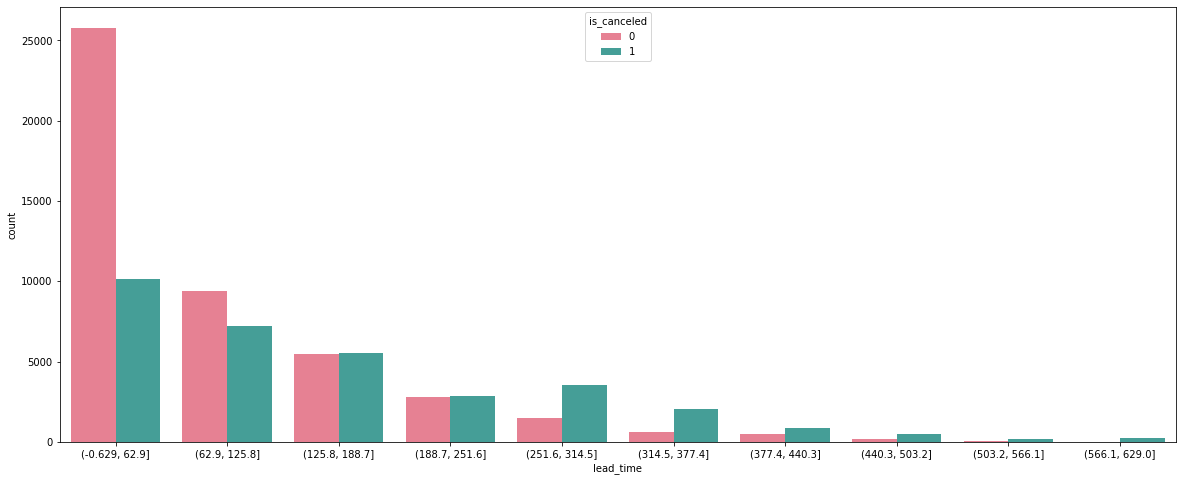

In [193]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 8
sns.countplot(x=pd.cut(hbd["lead_time"], 10), hue='is_canceled', data = hbd, palette="husl")

- Le prenotazioni più frequenti sono quelle a breve termine, ovvero senza lunghi periodi fra il momento della prenotazione e l'arrivo in hotel
- Medesima cosa vale per le cancellazioni, anche esse maggiori nelle prenotazioni a breve termine


### Variabile `total_of_special_requests`

- Visualizziamo la percentuale di cancellazione per i valori di `total_of_special_requests`

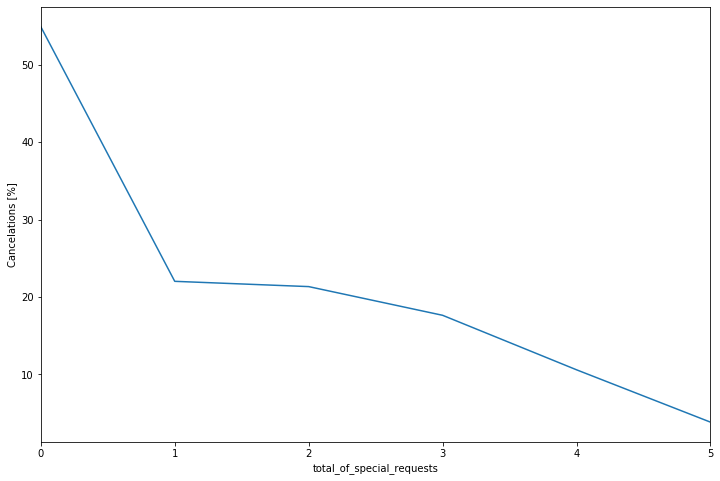

In [194]:
plt.figure(figsize=(12, 8))
plt.xlabel("Total of special request")
plt.ylabel("Cancelations [%]")
(100 * (hbd.groupby("total_of_special_requests").sum()["is_canceled"] / hbd["total_of_special_requests"].value_counts())).plot()

- Visualizziamo un l'istogramma in cui andiamo a quantificare la frequenza delle classi nei valori che la variabile assume

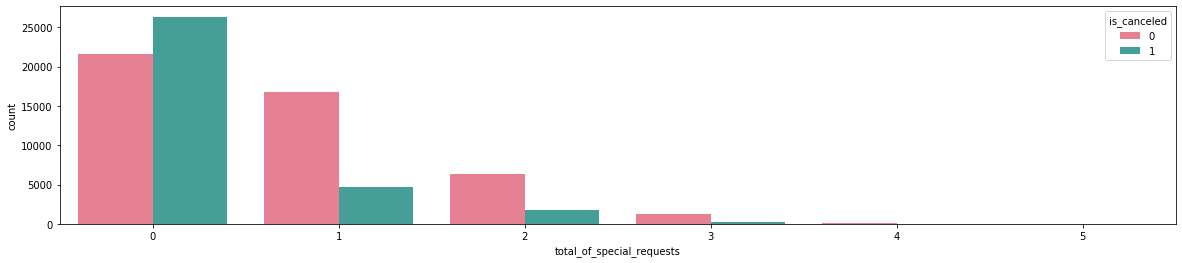

In [195]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 4
sns.countplot(x="total_of_special_requests", hue='is_canceled', data = hbd, palette="husl")

- All'aumentare del numero di richieste speciali la percentuale di cancellazioni diminuisce
    - Tanto più un cliente effettua richieste speciali tanto più è improbabile che cancelli la sua prenotazione

### Variabile `required_car_parking_spaces`

- Visualizziamo la percentuale di cancellazione per i valori di `required_car_parking_spaces`

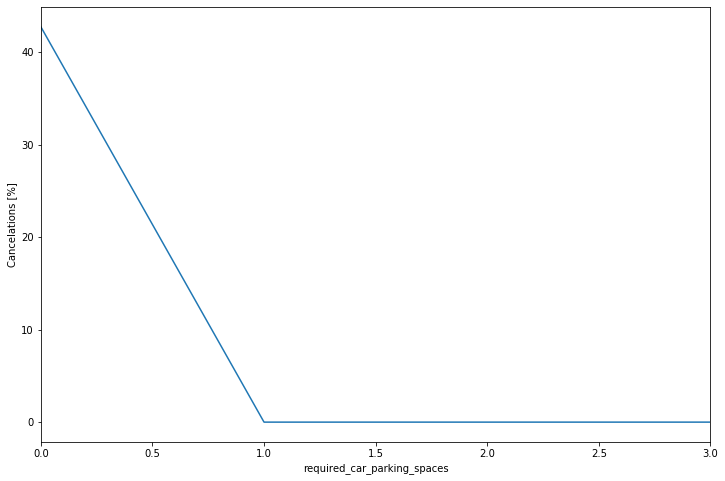

In [196]:
plt.figure(figsize=(12, 8))
plt.xlabel("Required car parking spaces")
plt.ylabel("Cancelations [%]")
(100 * (hbd.groupby("required_car_parking_spaces").sum()["is_canceled"] / hbd["required_car_parking_spaces"].value_counts())).plot()

- Visualizziammo anche il numero di prenotazioni effettuate per ciacun valore di `required_car_parking_spaces`

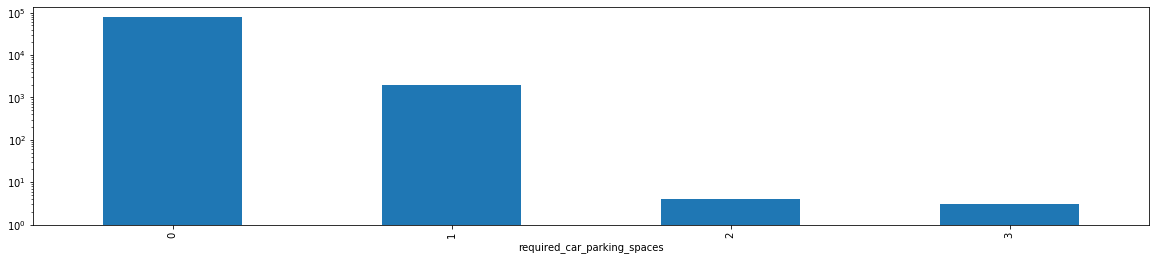

In [197]:
hbd.groupby("required_car_parking_spaces").size().plot.bar(log=True)

- Nessuna prenotazione per la quale era previsto almeno un posto macchina è mai stata cancellata
    - Chi viene in macchina in genere non cancella la propria prenotazione 

### Variabile `previous_cancellations`

- Visualizziamo la percentuale di cancellazione per i valori di `previous_cancellations`

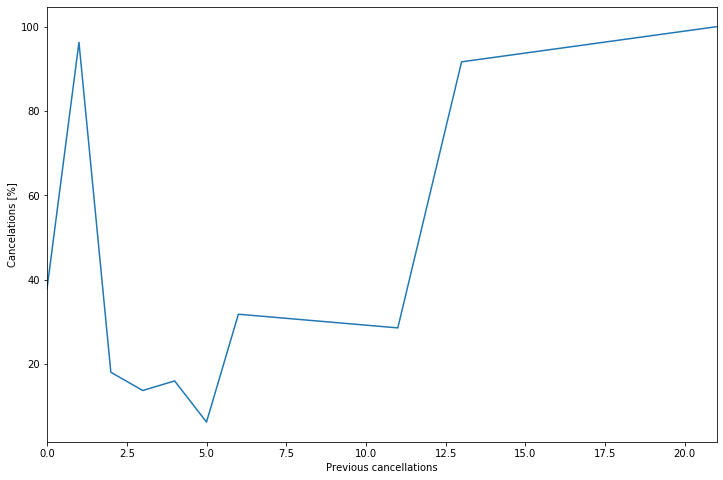

In [198]:
plt.figure(figsize=(12, 8))
plt.xlabel("Previous cancellations")
plt.ylabel("Cancelations [%]")
(100 * (hbd.groupby("previous_cancellations").sum()["is_canceled"] / hbd["previous_cancellations"].value_counts())).plot()

- Eccetto inizialmente, all'aumentare del numero di prenotazioni già cancellate sembra essere sempre più probabile un'ulteriore cancellazione
    - Chi ha già cancellato molte prenotazioni probabilmente lo rifarà, tanto più sono le cancellazioni fatte

### Variabile `booking_changes`

- Visualizziamo la percentuale di cancellazione per i valori di `booking_changes`

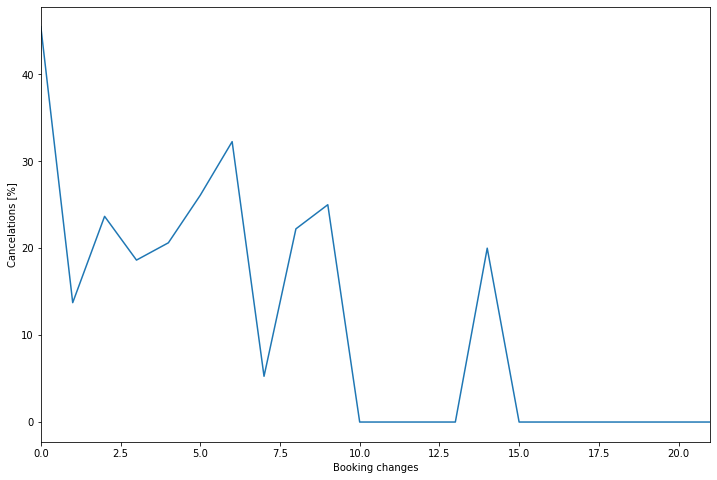

In [199]:
plt.figure(figsize=(12, 8))
plt.xlabel("Booking changes")
plt.ylabel("Cancelations [%]")
(100 * (hbd.groupby("booking_changes").sum()["is_canceled"] / hbd["booking_changes"].value_counts())).plot()

- Visualizziamo un l'istogramma in cui andiamo a quantificare la frequenza delle classi nei valori che la variabile assume

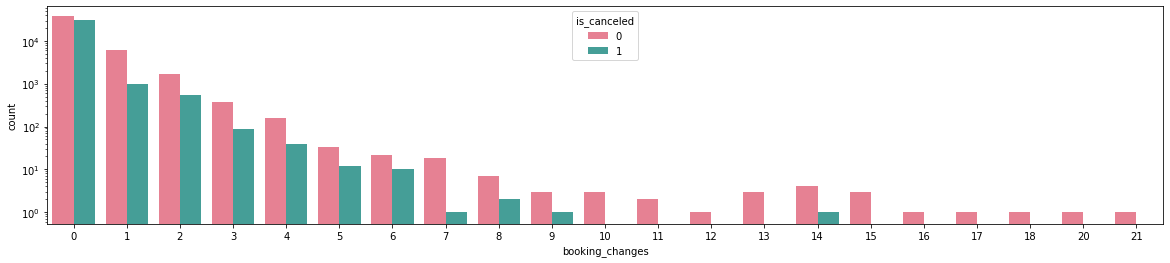

In [200]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 4
sns.countplot(x="booking_changes", hue='is_canceled', data = hbd, palette="husl", log=True)

- All'aumentare del numero di richieste di cambiamento la percentuale di cancellazioni tende a diminuire
    - Tanti più cambiamenti un cliente richiede, tanto più è improbabile che cancelli la sua prenotazione






- Mostriamo ora la variabile `country`

### Variabile `country`

- Valutiamo, per ciascuno stato, il numero di prenotazioni e cancellazioni

In [201]:
cancellation_by_state = hbd.groupby(['country']).sum()["is_canceled"]
reservation_by_state = hbd.groupby(['country']).size()

- Memorizziamo i primi 10 stati per numero di prenotazioni

In [202]:
bigger_states = reservation_by_state.sort_values(ascending=False).head(10)

- Visualizziamo due grafici a torta in cui vengono mostrati:
    - Gli stati con più prenotazioni
    - Gli stati con più cancellazioni

[Text(0, 0.5, 'Numero di cancellazioni')]

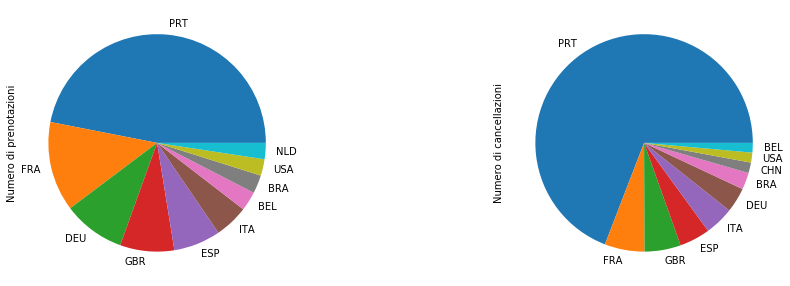

In [203]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
reservation_by_state.sort_values(ascending=False).head(10).plot.pie(ax=ax1)
cancellation_by_state.sort_values(ascending=False).head(10).plot.pie(ax=ax2)
ax1.set(ylabel="Numero di prenotazioni")
ax2.set(ylabel="Numero di cancellazioni")

- Lo stato che predomica maggiormente è _PRT_ , ovvero il Portogallo
- Poichè l'hotel è situato in Portogallo è un risultato tutto sommato scontato 

- Visualizziamo un grafico a barre con la percentuale di cancellazione relativa agli stati
    - Indichiamo colorando in modo diverso gli stati che risultano essere presenti nell'insieme `bigger_states`, ovvero i primi 10 stati per numero di prenotazioni
- Calcoliamo dunque la percentuale di cancellazioni di tutti gli statti

In [204]:
ratio_cancellation_by_state = (100* cancellation_by_state / reservation_by_state).sort_values(ascending=False)

- Mostraimo prima l'insieme di stati che presenta percentuale di cancellazione pari al 100%
    - Definisco i colori delle barre in funzione della presenza o meno dello stato in `bigger_states`

In [205]:
state100 = ratio_cancellation_by_state[ratio_cancellation_by_state==100]
condition = state100.index.isin(bigger_states.index)
colors = ""
for element in condition:
    colors += "b" if element == False else "r" 

Text(0, 0.5, 'Tasso di cancellazione')

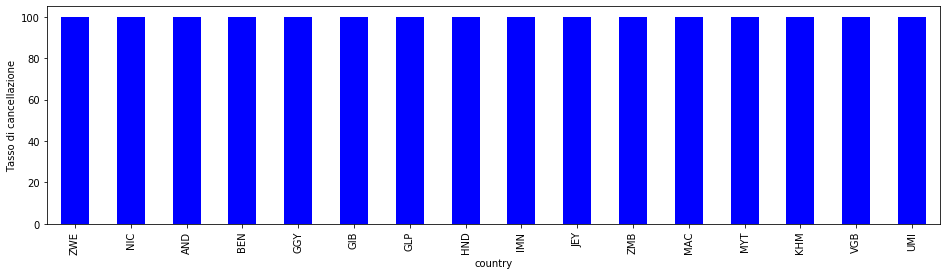

In [206]:
state100.plot.bar(figsize=(16,4), color = list(colors))
plt.ylabel("Tasso di cancellazione")

- Nessuno stato con un gran numero di prenotazioni ha percentuale di cancellazione pari a 100%
- Proviamo ora con i 30 stati successivi, replicando lo stesso approccio

In [207]:
statenot100 = ratio_cancellation_by_state[ratio_cancellation_by_state!=100].head(30)
condition = statenot100.index.isin(bigger_states.index)
colors = ""
for element in condition:
    colors += "b" if element == False else "r" 

Text(0, 0.5, 'Tasso di cancellazione')

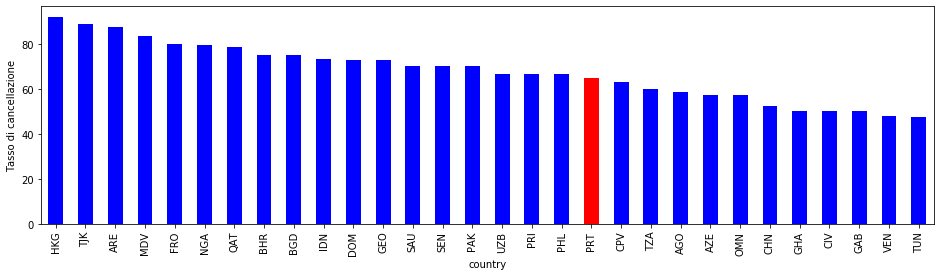

In [208]:
statenot100.plot.bar(figsize=(16,4), color = list(colors))
plt.ylabel("Tasso di cancellazione")

- In questo grafico troviamo il Portogallo ( _PRT_ ), nonchè lo stato con maggior numero di prenotazioni (e maggior numero di cancellazioni)
- Mostriamo la percentuale esatta

In [209]:
ratio_cancellation_by_state["PRT"]

64.85543530931999

- I portoghesi tendono a cancellare le proprie prenotazioni molto frequentemente


- Andiamo ora ad analizzare la variabile `deposit_type` e tutte le variabili che trattano il periodo di arrivo e la permanenza in albergo, in particolare:
    - `stays_in_weekend_nights`
    - `stays_in_week_nights`
    - `arrival_date_day`
    - `arrival_date_month`, 
    - `arrival_date_week_number` 

### Variabile `deposit_type`

- Visualizziamo due grafici a torta
    - Nel primo per ogni valore è mostrato il numero di prenotazioni
    - Nel secondo per ogni valore è mostrato il numero di cancellazioni

[Text(0, 0.5, 'Numero di cancellazioni')]

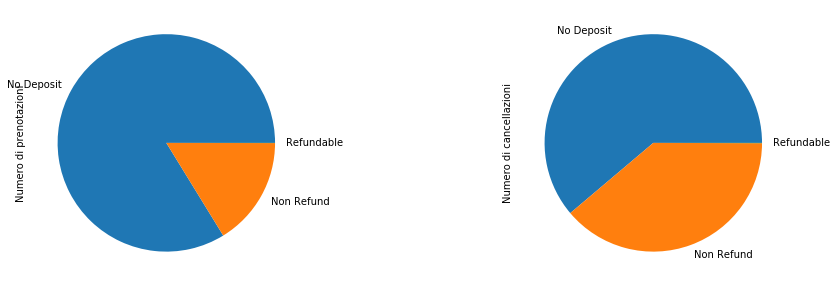

In [210]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
hbd["deposit_type"].value_counts().plot.pie(ax=ax1)
hbd.groupby("deposit_type").sum()["is_canceled"].plot.pie(ax=ax2)
ax1.set(ylabel="Numero di prenotazioni")
ax2.set(ylabel="Numero di cancellazioni")

- Il valore Refundable è praticamente inesistente

In [211]:
hbd["deposit_type"].value_counts()

No Deposit    66428
Non Refund    12853
Refundable       20
Name: deposit_type, dtype: int64

- Visualizziamo un grafico a barre di `deposit_type`, in cui in viene visualizzato per ciascun valore la percentuale di cancellazioni registrata

Text(0, 0.5, 'Cancelations [%]')

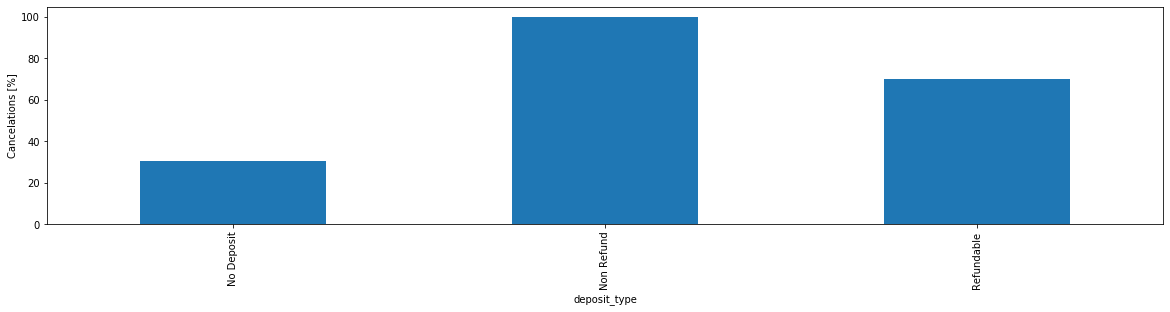

In [212]:
(100 * hbd.groupby("deposit_type").sum()["is_canceled"] / hbd["deposit_type"].value_counts()).plot.bar()
plt.ylabel("Cancelations [%]")

- Visualizziamo i valori esatti

In [213]:
(hbd.groupby("deposit_type").sum()["is_canceled"] / hbd["deposit_type"].value_counts())

deposit_type
No Deposit    0.304570
Non Refund    0.998133
Refundable    0.700000
dtype: float64

- Il grafico evidenzia che per il valore 'Non Refund' la percentuale di cancellazioni è pari quasi al 100%

- E' un po controintuitivo considerando il suo significato
    - Verifichiamo, per averne certezza, quante istanze con valore `Non Refund` sono state cancellate e quante no

In [214]:
hbd[hbd["deposit_type"] == "Non Refund"]["is_canceled"].value_counts()

1    12829
0       24
Name: is_canceled, dtype: int64

- Effettivamente pare che quasi tutte le prenotazioni _Non Refund_ siano state cancellate
    - Poichè pare un fatto particolarmente strano, sarà opportuno verificare in modo attento quanto questa variabile incida sul risultato

### Variabili `stays_in_weekend_nights`, `stays_in_week_nights`

- Mostriamo due grafici a barre in cui visualizziamo per ogni valore delle variabili `stays_in_weekend_nights` e `stays_in_week_nights`, ovvero il numero di notti prenotate rispettivamente durante il finesettimana e non durante il finesettimana, la percentuale di cancellazioni

Text(0, 0.5, 'Cancelations [%]')

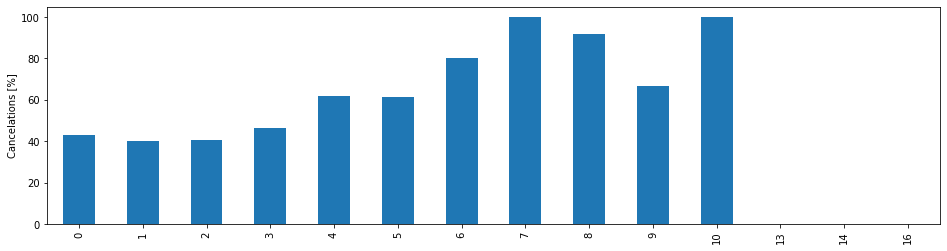

In [215]:
(100 * hbd.groupby("stays_in_weekend_nights").sum()["is_canceled"] / hbd["stays_in_weekend_nights"].value_counts()).plot.bar(figsize=(16,4))
plt.ylabel("Cancelations [%]")

Text(0, 0.5, 'Cancelations [%]')

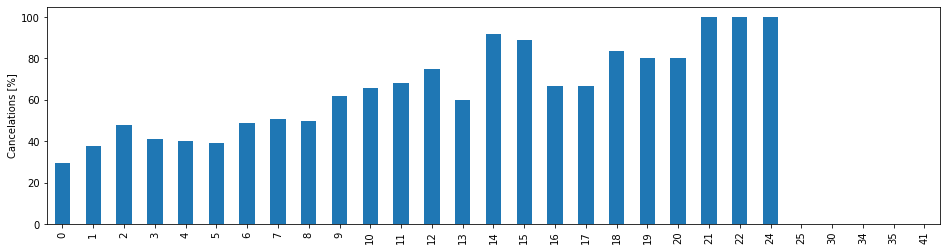

In [216]:
(100 * hbd.groupby("stays_in_week_nights").sum()["is_canceled"] / hbd["stays_in_week_nights"].value_counts()).plot.bar(figsize=(16,4))
plt.ylabel("Cancelations [%]")

- In entrambi i casi possiamo notare all'aumentare del numero di notti prenotate i clienti tendono a cancellare le prenotazioni con più frequenza
    - Vengono raggiunti picchi pari al 100%

### Variabili `arrival_date_day`, `arrival_date_month`, `arrival_date_week_number` 

- Mostriamo le percentuali di cancellazione delle variabili `arrival_date_day`, `arrival_date_month`, `arrival_date_week_number`

Text(0, 0.5, 'Cancelations [%]')

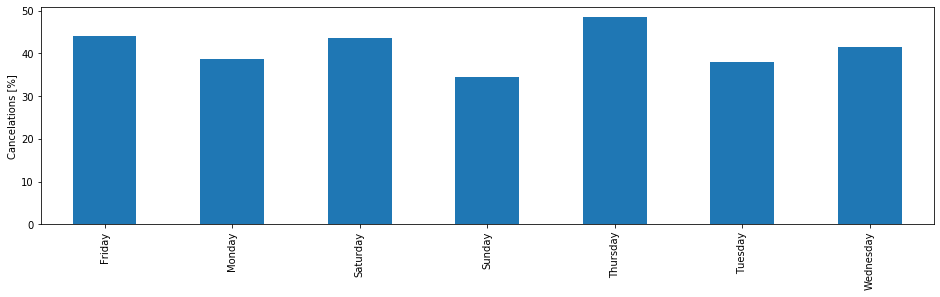

In [217]:
(100 * hbd.groupby("arrival_date_day").sum()["is_canceled"] / hbd["arrival_date_day"].value_counts()).plot.bar(figsize=(16,4))
plt.ylabel("Cancelations [%]")

Text(0, 0.5, 'Cancelations [%]')

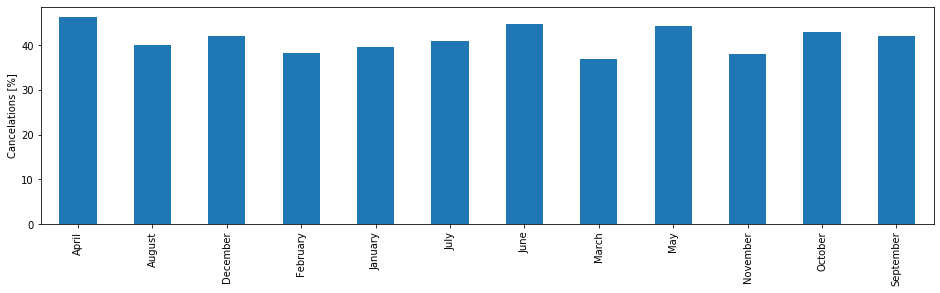

In [218]:
(100 * hbd.groupby("arrival_date_month").sum()["is_canceled"] / hbd["arrival_date_month"].value_counts()).plot.bar(figsize=(16,4))
plt.ylabel("Cancelations [%]")

Text(0, 0.5, 'Cancelations [%]')

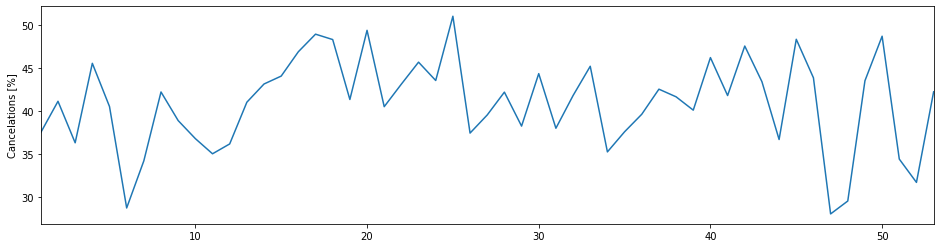

In [219]:
(100 * hbd.groupby("arrival_date_week_number").sum()["is_canceled"] / hbd["arrival_date_week_number"].value_counts()).plot(figsize=(16,4))
plt.ylabel("Cancelations [%]")

- Per quanto riguarda mese e giorno della settimana sono presenti piccole fluttuazzioni 
- Per quanto riguarda il numero della settimana dell'anno, possiamo notare periodi in cui il numero di prenotazioni cancellate rispetto al totale sono considerevoli

### Qualche altra variabile ...

- Mostriamo infine rapidamente la percentuale di prenotazioni cancellate di qualche altra variabile, al fine di comprendere il dominio in cui lavoriamo correttamente
    - Assieme alle percentuali aggiungiamo anche la distribuzione delle prenotazioni

[Text(0, 0.5, 'Numero di prenotazioni')]

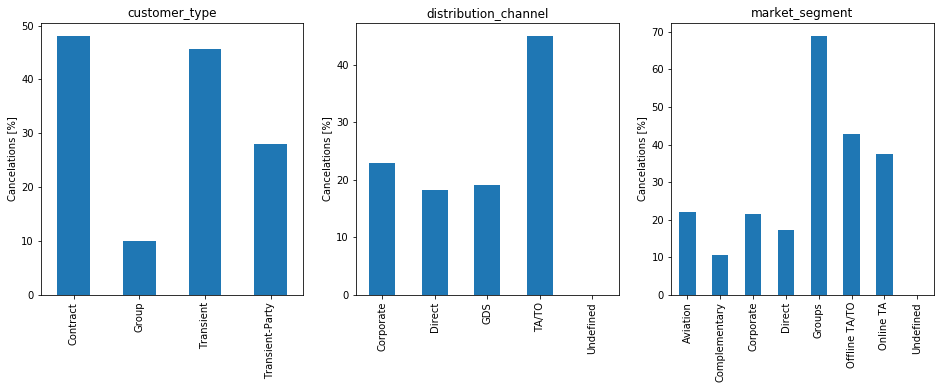

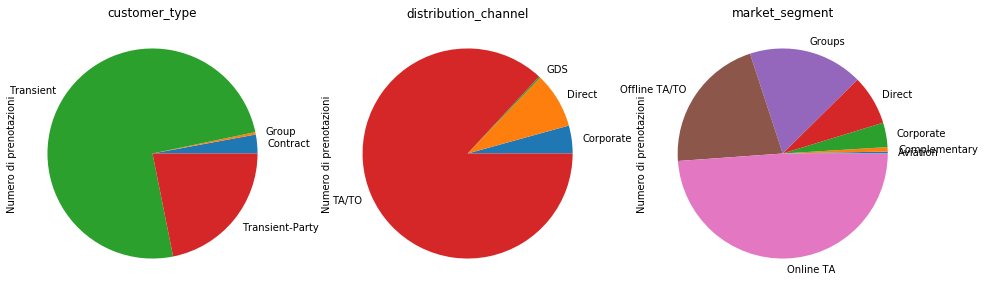

In [220]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.set(ylabel="Cancelations [%]")
ax2.set(ylabel="Cancelations [%]")
ax3.set(ylabel="Cancelations [%]")
ax1.set_title('customer_type')
ax2.set_title('distribution_channel')
ax3.set_title('market_segment')
(100 * hbd.groupby("customer_type").sum()["is_canceled"] / hbd["customer_type"].value_counts()).plot.bar(ax=ax1)
(100 * hbd.groupby("distribution_channel").sum()["is_canceled"] / hbd["distribution_channel"].value_counts()).plot.bar(ax=ax2)
(100 * hbd.groupby("market_segment").sum()["is_canceled"] / hbd["market_segment"].value_counts()).plot.bar(ax=ax3)
fig = plt.figure(figsize=(16, 5))
ax4 = fig.add_subplot(131)
ax5 = fig.add_subplot(132)
ax6 = fig.add_subplot(133)
ax4.set_title('customer_type')
ax5.set_title('distribution_channel')
ax6.set_title('market_segment')
hbd.groupby("customer_type").size().plot.pie(ax=ax4)
hbd.groupby("distribution_channel").size().plot.pie(ax=ax5)
hbd.groupby("market_segment").size().plot.pie(ax=ax6)
ax4.set(ylabel="Numero di prenotazioni")
ax5.set(ylabel="Numero di prenotazioni")
ax6.set(ylabel="Numero di prenotazioni")

[Text(0, 0.5, 'Numero di prenotazioni')]

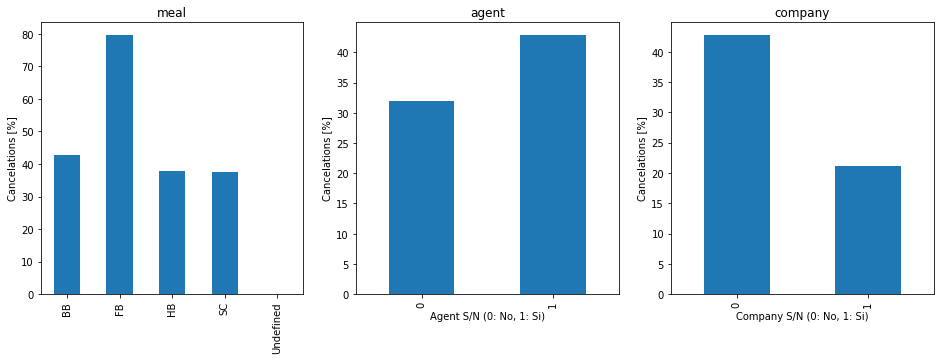

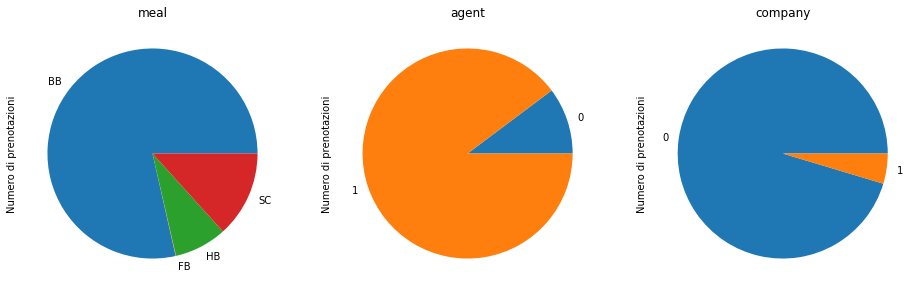

In [221]:
fig = plt.figure(figsize=(16, 5))
ax4 = fig.add_subplot(131)
ax5 = fig.add_subplot(132)
ax6 = fig.add_subplot(133)
ax4.set_title('meal')
ax5.set_title('agent')
ax6.set_title('company')
ax4.set(ylabel="Cancelations [%]")
ax5.set(ylabel="Cancelations [%]")
ax6.set(ylabel="Cancelations [%]")
(100 * hbd.groupby("meal").sum()["is_canceled"] / hbd["meal"].value_counts()).plot.bar(ax=ax4)
(100 * hbd.groupby("agent").sum()["is_canceled"] / hbd["agent"].value_counts()).plot.bar(ax=ax5)
(100 * hbd.groupby("company").sum()["is_canceled"] / hbd["company"].value_counts()).plot.bar(ax=ax6)
ax5.set(xlabel="Agent S/N (0: No, 1: Si)")
ax6.set(xlabel="Company S/N (0: No, 1: Si)")
fig = plt.figure(figsize=(16, 5))
ax4 = fig.add_subplot(131)
ax5 = fig.add_subplot(132)
ax6 = fig.add_subplot(133)
ax4.set_title('meal')
ax5.set_title('agent')
ax6.set_title('company')
hbd.groupby("meal").size().plot.pie(ax=ax4)
hbd.groupby("agent").size().plot.pie(ax=ax5)
hbd.groupby("company").size().plot.pie(ax=ax6)
ax4.set(ylabel="Numero di prenotazioni")
ax5.set(ylabel="Numero di prenotazioni")
ax6.set(ylabel="Numero di prenotazioni")

- Anche qui esistono valori con una percentuale di cancellazione molto elevata (fino all'80%) e altri con una percentuale molto bassa

- Per esempio...
    - Le prenotazioni con valore `FB` nella variabile `meal` sono state per circa l'80% cancellate 

## Classificazione 

- Convertiamo, per maggiore chiarezza, i valori della variabile `is_canceled` (ovvero 0 e 1) in `N` e `Y`:
    - `0` diventa `N`, ovvero non cancellata
    - `1` diventa `Y`, ovvero cancellata

In [222]:
hbd["is_canceled"] = hbd["is_canceled"].map(lambda value: "N" if value is 0 else "Y")
hbd["is_canceled"].unique()

array(['N', 'Y'], dtype=object)

- Impostiamo come variabile da predire la classe `is_canceled` e come variabili predittive tutte le altre

In [223]:
y = hbd["is_canceled"]
X = hbd.drop(columns="is_canceled")

- Molte variabili sono categoriche, è quindi necessario applicare la binarizzazione delle feature, ovvero convertire ciascuna di esse in una o più variabili binarie. 

- La conversione viene eseguita in modo molto basilare dal comando `get_dummies`
    - NB: non sono previste variabili per tutti quei valori non presenti nel dataset

In [224]:
X = pd.get_dummies(X)

- Otteniamo un numero di variabili pari a ...

In [225]:
X.shape[1]

248

- Vengono mostrate per completezza tutte le variabili ottenute

In [226]:
X.columns.tolist()

['lead_time',
 'arrival_date_week_number',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'arrival_date_day_Friday',
 'arrival_date_day_Monday',
 'arrival_date_day_Saturday',
 'arrival_date_day_Sunday',
 'arrival_date_day_Thursday',
 'arrival_date_day_Tuesday',
 'arrival_date_day_Wednesday',
 'arrival_date_month_April',
 'arrival_date_month_August',
 'arrival_date_month_December',
 'arrival_date_month_February',
 'arrival_date_month_January',
 'arrival_date_month_July',
 'arrival_date_month_June',
 'arrival_date_month_March',
 'arrival_date_month_May',
 'arrival_date_month_November',
 'arrival_date_month_October',
 'arrival_date_month_September',
 'meal_BB',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'meal_Undefined',
 'country_ABW',

- Suddividiamo i dati in un training set e in un validation set con la funzione `train_test_split` con proporzione 66-33

In [227]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=1/3, 
    random_state=42
)

- Definiamo un modello di regressione logistica più semplice possibile, configurandone l'implementazione e il seed per la casualità
  - gli altri parametri sono lasciati ai valori di default, ad es. la regolarizzazione applicata è L2 con C=1

In [228]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model = LogisticRegression(solver="saga", random_state=42)  

- Addestriamo il modello sui dati

In [229]:
%time model.fit(X_train, y_train)

Wall time: 20.1 s


C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

- Mostriamo le classi previste dal modello

In [230]:
model.classes_

array(['N', 'Y'], dtype=object)

- NB: Quando effettuiamo una predizione di probabilità otteniamo due valori ([a, b])
    - Il primo valore (a) si riferisce alla probabilità di ottenere la classe `N`
    - Il secondo valore (b) si riferisce alla probabilità di ottenere la classe `Y`


- Come mostrato di seguito...

In [231]:
model.predict_proba(X_val[:3])

array([[0.19018121, 0.80981879],
       [0.10774354, 0.89225646],
       [0.88131685, 0.11868315]])

In [232]:
model.predict(X_val[:3])

array(['Y', 'Y', 'N'], dtype=object)

- Definiamo una funzione per ottenere le informazioni utili per valutare un modello di classificazione

- Oltre all'accuratezza come percentuale di classificazioni corrette, esistono altri modi per valutare l'accuratezza di un classificatore
    - Precision e recall sono particolarmente utili in caso di sbilanciamento tra le classi, per cui l'accuratezza può non essere un indicatore affidabile

In [233]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

def print_model_informations(model,  X_train, y_train, X_val, y_val):
    y_pred = model.predict(X_val)
    print("Accuracy =", model.score(X_val, y_val),"        ( Accuracy on training set =", model.score(X_train, y_train),")")
    print("\nPrecision (Y) =", precision_score(y_val,y_pred, pos_label="Y"))
    print("Precision (N) =", precision_score(y_val,y_pred, pos_label="N"))
    print("Precision =", precision_score(y_val,y_pred, average="macro"))
    print("\nRecall (Y) =", recall_score(y_val,y_pred, pos_label="Y"))
    print("Recall (N) =", recall_score(y_val,y_pred, pos_label="N"))
    print("Recall =", recall_score(y_val,y_pred, average="macro"))
    print("\nF1 Score (Y) =", f1_score(y_val,y_pred, pos_label="Y"))
    print("F1 Score (N) =", f1_score(y_val,y_pred, pos_label="N"))
    print("F1 Score =", f1_score(y_val,y_pred, average="macro"))
    print("\nMatrice di confusione:")
    cm = confusion_matrix(y_val, y_pred)
    print(pd.DataFrame(cm, index=model.classes_, columns=model.classes_))

- Calcoliamo le misure del nostro modello 

In [234]:
print_model_informations(model, X_train, y_train, X_val, y_val)

Accuracy = 0.7946205644246047         ( Accuracy on training set = 0.7960920801255982 )

Precision (Y) = 0.8481325748206777
Precision (N) = 0.7710377152823196
Precision = 0.8095851450514986

Recall (Y) = 0.6201284022063478
Recall (N) = 0.920130081300813
Recall = 0.7701292417535803

F1 Score (Y) = 0.7164272656045966
F1 Score (N) = 0.8390119503009816
F1 Score = 0.777719607952789

Matrice di confusione:
       N     Y
N  14147  1228
Y   4201  6858


- Per avere una valutazione più completa del modello ottenuto, possiamo metterlo a confronto con quello che accadrebbe prendendo decisioni casuali, ovvero dotandoci di un modello randomico
    - In questo caso _DummyClassifier_

In [235]:
from sklearn.dummy import DummyClassifier

In [236]:
random = DummyClassifier(strategy="uniform", random_state=42)
random.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=42, strategy='uniform')

In [237]:
random.score(X_val, y_val)

0.49708708481501096

- Abbiamo quindi ottenuto un modello che ci consente di intraprendere decisioni più accurate di come le faremmo casualmente

### Standardizzazione

- Possiamo standardizzare i dati per vedere se il modello migliora

In [238]:
from sklearn.preprocessing import StandardScaler

model_stand = Pipeline([
    ("scaler", StandardScaler()),
    ("log", LogisticRegression(solver="saga", random_state=42))
])
model_stand.fit(X_train, y_train)
print_model_informations(model_stand, X_train, y_train, X_val, y_val)

C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy = 0.8097904214269501         ( Accuracy on training set = 0.8101462159759396 )

Precision (Y) = 0.8362136247073252
Precision (N) = 0.7962210134554824
Precision = 0.8162173190814037

Recall (Y) = 0.6781806673297767
Recall (N) = 0.9044552845528455
Recall = 0.7913179759413111

F1 Score (Y) = 0.7489514679448771
F1 Score (N) = 0.8468940316686967
F1 Score = 0.7979227498067869

Matrice di confusione:
       N     Y
N  13906  1469
Y   3559  7500


- La standardizzazione comporta un miglioramento sotto più punti di vista

### Regolarizzazione

- Nella regressione logistica possiamo applicare le teniche di regolarizzazione


- Verifichiamo utilizzando la regressione lasso se ci sono coefficienti che si azzerano per valori di alpha non elevati
    - E' spesso indice di collinearità

In [239]:
model_reg_1 = Pipeline([
    ("scaler", StandardScaler()),
    ("log", LogisticRegression(solver="saga", random_state=42, penalty="l1", C=1))
])
%time model_reg_1.fit(X_train, y_train)

Wall time: 27 s


C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('log',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=42,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [240]:
coeff = pd.Series(model_reg_1.named_steps["log"].coef_[0], index=X.columns)
', '.join(coeff[coeff==0].index)

'meal_Undefined, country_BDI, country_BHS, country_BWA, country_CAF, country_CYM, country_DJI, country_DMA, country_ESP, country_FJI, country_IMN, country_KHM, country_KIR, country_LCA, country_MDG, country_MWI, country_NAM, country_NPL, country_PLW, country_PYF, country_SDN, country_SMR, country_SUR, country_TGO, country_VGB, country_ZMB, market_segment_Undefined, distribution_channel_Undefined, reserved_room_type_H, reserved_room_type_L, reserved_room_type_P'

- Sono state rimosse tutte le variabili _undefined_ 
    - Il valore undefined è un valore utilizzato quando non viene selezionato nessun valore per una certa variabile
        - Nel caso della variabile inziale `meal`, per esempio, viene assegnato se non seleziono nessuna combinazione di pasti
    - Di fatto questo tipo di variabile è deducibile dalle altre variabili ottenute, mediante binarizzazione, dalla stessa variabile categorica  


- Per il resto nulla di particolarmente interessante, se non la rimozione di molte delle variabili binarie relative agli stati
    - Poichè sono presenti quasi tutti gli stati del mondo (~196) è un risultato comprensibile


- Applichiamo nuovamente la regolarizzazione lasso, ma questa volta utilizziamo un alpha più elevato al fine di annullare molte più variabili
    - Ci servirà per il prossimo step

In [241]:
model_reg_2 = Pipeline([
    ("scaler", StandardScaler()),
    ("log", LogisticRegression(solver="saga", random_state=42, penalty="l1", C=0.002))
])  
%time model_reg_2.fit(X_train, y_train)

Wall time: 24.7 s


C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('log',
                 LogisticRegression(C=0.002, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=42,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

- Andiamo a visualizzare i coefficienti più grandi (in valore assoluto) per comprendere quali siano le feature più rilevanti

In [242]:
pd.Series(model_reg_2.named_steps["log"].coef_[0], index=X.columns).sort_values(ascending=False).head(10).append(
pd.Series(model_reg_2.named_steps["log"].coef_[0], index=X.columns).sort_values(ascending=False).tail(10))

deposit_type_Non Refund           0.644021
market_segment_Online TA          0.512518
country_PRT                       0.511609
lead_time                         0.436877
previous_cancellations            0.227620
adr                               0.135569
customer_type_Transient           0.116751
stays_in_week_nights              0.110001
distribution_channel_TA/TO        0.051753
country_CHN                       0.051374
company                          -0.038286
market_segment_Offline TA/TO     -0.049784
customer_type_Transient-Party    -0.062018
previous_bookings_not_canceled   -0.079668
country_FRA                      -0.097700
country_DEU                      -0.149741
booking_changes                  -0.159968
required_car_parking_spaces      -0.287879
total_of_special_requests        -0.517619
deposit_type_No Deposit          -0.645471
dtype: float64

- Visualizziamo anche l'intercetta

In [243]:
model_reg_2.named_steps["log"].intercept_

array([-0.18286659])

- Verifichiamo quanti coefficienti hanno valore diverso da zero

In [244]:
coeff = pd.Series(model_reg_2.named_steps["log"].coef_[0], index=X.columns)
coeff_not_zero = coeff[coeff!=0]
print(len(coeff_not_zero),"coefficienti hanno valore diverso da 0")

35 coefficienti hanno valore diverso da 0


- Le variabili con coefficiente più alto (in valore assoluto) mostrate sopra sono state soggetto di analisi in fase esplorativa in quanto considerate le più rilevanti
    - E' stato quindi tenuto in considerazione anche questo risultato per decidere quali variabili analizzare in fase esplorativa

#### Variabile `deposit_type`   

- Poichè `deposit_type` risulta essere una variabile di rilievo per il modello (e tenuto conto delle osservazioni fatte in fase di analisi esplorativa) si trova opportuno sperimentare l'addestramento di un modello senza essa
    - Effettuiamo una copia dei dataset `X_train` e `X_val` e rimuoviamo la variabile `deposit_type` 

In [245]:
X_train_no_deposit = X_train.copy()
X_val_no_deposit = X_val.copy()
X_train_no_deposit.drop(columns=['deposit_type_No Deposit', 'deposit_type_Non Refund','deposit_type_Refundable'], inplace=True)
X_val_no_deposit.drop(columns=['deposit_type_No Deposit', 'deposit_type_Non Refund','deposit_type_Refundable'], inplace=True)

- Creiamo il nuovo modello con la stessa configurazione di `model_stand` e lo addestriamo con una variabile in meno

In [246]:
model_no_deposit = Pipeline([
    ("scaler", StandardScaler()),
    ("log", LogisticRegression(solver="saga", random_state=42))
])   
model_no_deposit.fit(X_train_no_deposit, y_train)

C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('log',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

- Visualizziamo le metriche

In [247]:
print_model_informations(model_no_deposit, X_train_no_deposit, y_train, X_val_no_deposit, y_val)

Accuracy = 0.8001815843232201         ( Accuracy on training set = 0.7994968505873229 )

Precision (Y) = 0.7922695537792168
Precision (N) = 0.8049060479729322
Precision = 0.7985878008760745

Recall (Y) = 0.7080206166922868
Recall (N) = 0.8664715447154472
Recall = 0.787246080703867

F1 Score (Y) = 0.7477795817018431
F1 Score (N) = 0.834554908225271
F1 Score = 0.7911672449635571

Matrice di confusione:
       N     Y
N  13322  2053
Y   3229  7830


- Il modello non sembra aver subito in modo rilevante la mancanza della variabile `deposit_type`

### Cross-validation

- Quello che vogliamo fare ora è applicare la **Grid Search** e **K-fold cross validation** per trovare gli iperparametri migliori
 
- Poichè il dataset è molto ampio e le variabili sono molte, la ricerca degli iperparametri ottimali risulta essere molto dispendiosa.

- Riduciamo la dimensione del dataset in termini di variabili 


- Realizzo una copia dei dataset di training e validation

In [248]:
X_train_v2 = X_train.copy()
y_train_v2 = y_train.copy()
X_val_v2 = X_val.copy()
y_val_v2 = y_val.copy()

- Attualmente presentano le seguenti dimensioni...

In [249]:
X_train_v2.shape, X_val_v2.shape

((52867, 248), (26434, 248))

- Utilizziamo la serie `coeff_not_zero` ottenuta precedentemente
    - Contiene i coefficienti diversi da zero ottenuti dall'addestramento di un modello di regressione logistica con regolarizzazione Lasso, alpha = 0.003 e variabili standardizzate
    
    
- Rimuoviamo dalle copie dei dataset tutte le variabili non presenti all'interno della serie `coeff_not_zero`
    - Vengono quindi rimosse dai nostri dataset le variabili meno rilevanti per il modello precedente 

In [250]:
X_train_v2 = X_train_v2[coeff_not_zero.index]
X_val_v2 = X_val_v2[coeff_not_zero.index]
print("Ho scartato", X_train.shape[1] - coeff_not_zero.shape[0], "variabili")

Ho scartato 213 variabili


- Le nuove dimensioni sono:

In [251]:
X_train_v2.shape, X_val_v2.shape

((52867, 35), (26434, 35))

- Addestriamo un modello su questo nuovo training set
    - Viene utilizzata la configurazione di `model_stand`

In [252]:
model_stand_v2 = Pipeline([
    ("scaler", StandardScaler()),
    ("log", LogisticRegression(solver="saga", random_state=42))
])   
model_stand_v2.fit(X_train_v2, y_train_v2)

C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('log',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

- Visulizziamone le metriche...

In [253]:
print_model_informations(model_stand_v2, X_train_v2, y_train_v2, X_val_v2, y_val_v2)

Accuracy = 0.8071801467806613         ( Accuracy on training set = 0.8045472601055479 )

Precision (Y) = 0.8381352087114338
Precision (N) = 0.7916903167215348
Precision = 0.8149127627164843

Recall (Y) = 0.668143593453296
Recall (N) = 0.9071869918699187
Recall = 0.7876652926616073

F1 Score (Y) = 0.7435471698113209
F1 Score (N) = 0.8455126845088352
F1 Score = 0.7945299271600781

Matrice di confusione:
       N     Y
N  13948  1427
Y   3670  7389


- E confrontiamole con quelle ottenute dalla stessa configurazione addestrata però sul dataset completo di tutte le variabili 

In [254]:
print_model_informations(model_stand, X_train, y_train, X_val, y_val)

Accuracy = 0.8097904214269501         ( Accuracy on training set = 0.8101462159759396 )

Precision (Y) = 0.8362136247073252
Precision (N) = 0.7962210134554824
Precision = 0.8162173190814037

Recall (Y) = 0.6781806673297767
Recall (N) = 0.9044552845528455
Recall = 0.7913179759413111

F1 Score (Y) = 0.7489514679448771
F1 Score (N) = 0.8468940316686967
F1 Score = 0.7979227498067869

Matrice di confusione:
       N     Y
N  13906  1469
Y   3559  7500


- Il modello non sembra aver subito la mancanza delle variabili, le metriche sono estremamente simili


- Definiamo uno `StatifiedKFold` per effettuare la cross-validation
    - Dovendo addestrare un modello a riconoscere delle classi, è opportuno che le proporzioni di ciascuna classe nei fold siano uguali
    - `StratifiedKFold` è una variante di `KFold` che garantisce uguale distribuzione delle classi tra un fold e l'altro

In [255]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
skf = StratifiedKFold(3, shuffle=True, random_state=42)

In [256]:
for train, val in skf.split(X_train_v2, y_train_v2):
    print(y_train.iloc[val].value_counts())

N    10284
Y     7339
Name: is_canceled, dtype: int64
N    10284
Y     7339
Name: is_canceled, dtype: int64
N    10283
Y     7338
Name: is_canceled, dtype: int64


- Definiamo una "griglia" con liste di valori possibili per gli iperparametri di un modello, al fine di testare tutte le combinazioni possibili mediante la grid search
    - Il numero di istanze combinato al numero di variabili rende impraticabile l'uso di feature polinomiali all'interno della Grid Search

In [257]:
mod = Pipeline([
    ("scaler", None),
    ("lr", LogisticRegression(solver="saga", random_state=42))
])
grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["none"]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2", "l1"],
        "lr__C": np.logspace(-2, 2, 5)
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["elasticnet"],
        "lr__C": np.logspace(-2, 2, 5),
        "lr__l1_ratio": [0.2, 0.5, 0.7]
    }
]

- Definiamo la grid search, specificando il modello, la lista di griglie e lo splitter per la cross-validation (usiamo lo `StratifiedKFold` creato sopra)

In [258]:
gs = GridSearchCV(mod, grid, cv=skf)

- Effettuiamo quindi la ricerca sui dati 

In [259]:
%time gs.fit(X_train_v2, y_train_v2)

C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarni

C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarni

C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarni

C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarni

C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarni

Wall time: 7min 36s


C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler', None),
                                       ('lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='warn',
                                                           n_jobs=None,
                                                          

- Possiamo verificare la migliore combinazione di iperparametri
    -  La metrica di riferimento di default è l'accuratezza, cioè la percentuale di classificazioni corrette

In [260]:
gs.best_params_

{'lr__C': 0.1,
 'lr__penalty': 'l2',
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

- E vedere tutti i dettagli
    - Selezioniamo le 5 parametrizzazioni con accuratezza migliore

In [261]:
result = pd.DataFrame(gs.cv_results_)
result.sort_values(by="rank_test_score", inplace=True)
result.reset_index(inplace=True, drop=True)
result.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__penalty,param_scaler,param_lr__C,param_lr__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.387018,0.022906,0.046315,0.002495,l2,"StandardScaler(copy=True, with_mean=True, with...",0.1,NaN,"{'lr__C': 0.1, 'lr__penalty': 'l2', 'scaler': ...",0.809283,0.803779,0.800522,0.804528,0.003616,1
1,2.774353,0.063505,0.043315,0.001248,l1,"StandardScaler(copy=True, with_mean=True, with...",1,NaN,"{'lr__C': 1.0, 'lr__penalty': 'l1', 'scaler': ...",0.809283,0.803779,0.800295,0.804453,0.003700,2
2,3.441342,0.031854,0.043991,0.000809,elasticnet,"StandardScaler(copy=True, with_mean=True, with...",1,0.2,"{'lr__C': 1.0, 'lr__l1_ratio': 0.2, 'lr__penal...",0.809170,0.803836,0.800295,0.804434,0.003648,3
3,3.148007,0.094371,0.045661,0.002486,elasticnet,"StandardScaler(copy=True, with_mean=True, with...",1,0.7,"{'lr__C': 1.0, 'lr__l1_ratio': 0.7, 'lr__penal...",0.809227,0.803779,0.800295,0.804434,0.003675,3
4,2.647000,0.117349,0.045667,0.002497,l2,"StandardScaler(copy=True, with_mean=True, with...",1,NaN,"{'lr__C': 1.0, 'lr__penalty': 'l2', 'scaler': ...",0.809170,0.803836,0.800238,0.804415,0.003669,5


- Andiamo a visualizzare le misure del miglior modello ottenuto

In [262]:
print_model_informations(gs, X_train_v2, y_train_v2, X_val_v2, y_val_v2)

Accuracy = 0.8070288265113111         ( Accuracy on training set = 0.8044905139311858 )

Precision (Y) = 0.8380617339990921
Precision (N) = 0.7915106117353309
Precision = 0.8147861728672114

Recall (Y) = 0.6677818970973868
Recall (N) = 0.9071869918699187
Recall = 0.7874844444836527

F1 Score (Y) = 0.7432942478989482
F1 Score (N) = 0.8454101888050429
F1 Score = 0.7943522183519955

Matrice di confusione:
       N     Y
N  13948  1427
Y   3674  7385


- Possiamo notare un valore leggermente più basso degli altri per quanto riguarda `Recall (Y)`, ovvero la percentuale di istanze cancellate che sono state classificate come tali.
    - Dal suo valore sappiamo che di tutte le prenotazioni cancellate il modello è in grado di trovarne il 67% circa
    - In compenso `Precision (Y)` è alta, sappiamo quindi che circa l'84% delle istanze che vengono classificate come cancellate lo sono veramente

### Test polinomiale con riduzione delle feature

- Proviamo come ultima strada a vedere se è possibile ottenere un modello migliore utilizzando le feature polinomiali
    - Come detto precedentemente il numero di istanze combinato al numero di variabili rende impraticabile l'uso di feature polinomiali
    - Riduciamo quindi ulteriormente il numero di feature
        - Per farlo utilizziamo il medesimo approccio proposto precedentemente: utilizziamo la regressione Lasso con un valore molto alto per rimuovere più variabili possibili, mantenendo le più rilevanti

In [263]:
model_reg_extreme = Pipeline([
    ("scaler", StandardScaler()),
    ("log", LogisticRegression(solver="saga", random_state=42, penalty="l1", C=0.0005))
])  
%time model_reg_extreme.fit(X_train, y_train)

Wall time: 17.5 s


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('log',
                 LogisticRegression(C=0.0005, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=42,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

- In numero di coefficienti diversi da 0 è...

In [264]:
coeff = pd.Series(model_reg_extreme.named_steps["log"].coef_[0], index=X.columns)
coeff_not_zero = coeff[coeff!=0]
len(coeff_not_zero)

11

- Viene realizzata una copia del dataset binarizzato iniziale, rimuovendo tutte le variabili non presenti fra quelle con coefficiente diverso da 0

In [265]:
X_train_poly = X_train[coeff_not_zero.index]
X_val_poly = X_val[coeff_not_zero.index]

- Si propone una Grid Search con features polinomiali, giusto per provare un paio di gradi possibili

In [266]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_model = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LogisticRegression(solver="saga", random_state=42))
])
grid = {
    "poly__degree": [2,3]
    }
gs_poly = GridSearchCV(polynomial_model, param_grid=grid)
%time gs_poly.fit(X_train_poly, y_train)

C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Wall time: 1min 29s


C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=False,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('linreg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                        

- Mostriamo tutte le parametrizzazioni ottenute

In [267]:
result_poly = pd.DataFrame(gs_poly.cv_results_)
result_poly.sort_values(by="rank_test_score", inplace=True)
result_poly.reset_index(inplace=True, drop=True)
result_poly

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.339334,1.438788,0.080333,0.013302,2,{'poly__degree': 2},0.809170,0.802247,0.802735,0.804717,0.003155,1
1,20.409672,0.669909,0.248660,0.008379,3,{'poly__degree': 3},0.808432,0.801566,0.802508,0.804169,0.003039,2


- Prendiamo il miglior modello e visualizziamone le metriche

In [268]:
print_model_informations(gs_poly, X_train_poly, y_train, X_val_poly, y_val)

Accuracy = 0.8048725126730726         ( Accuracy on training set = 0.8044148523653697 )

Precision (Y) = 0.8214402440352979
Precision (N) = 0.7960591133004926
Precision = 0.8087496786678953

Recall (Y) = 0.6817976308888688
Recall (N) = 0.8933983739837399
Recall = 0.7875980024363043

F1 Score (Y) = 0.7451329182725565
F1 Score (N) = 0.8419246092552866
F1 Score = 0.7935287637639215

Matrice di confusione:
       N     Y
N  13736  1639
Y   3519  7540


- Le feature polinomiali non hanno portato a grossi benefici

## Valutazione dei modelli di classificazione

### Intervallo di confidenza sui modelli

In [269]:
from scipy.stats import norm

- Definiamo una funzione `conf_interval` che calcoli gli estremi dell'intervallo di confidenza e restituisca una tupla con i due estremi, dove:
  - $a$ è l'accuratezza del modello misurata sul validation set
  - N è il numero di osservazioni nel validation set
  - Z è il valore tale per cui l'area sottesa dalla densità di probabilità $\varphi(x)$ della distribuzione normale standard tra -Z e Z sia il livello di confidenza 1-𝛼
  
- Poichè a noi interessa valutare i modelli con una condifidenza del 95%, possiamo ricavare dalle apposite tabelle di valori che, per 1-𝛼 = 0.95 (𝛼=0.05), Z = 1.96

In [270]:
def conf_interval(a, N, Z=1.96):
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

- Definisco ora una funzione `model_conf_interval` in modo che:
  - prenda in input un modello addestrato `model`, un validation set `X, y` e un livello di confidenza `level` (default 0.95)
  - restituisca l'intervallo di confidenza dell'accuratezza del modello, servendosi della funzione `conf_interval` sopra


In [271]:
def model_conf_interval(model, X, y, level=0.95):
    a = model.score(X, y)
    N = X.shape[0]
    Z = norm.ppf((1 + level) / 2)
    return conf_interval(a, N, Z)

### Confronto tra modelli

- Dati due modelli diversi, vogliamo poter valutare se l'accuratezza  𝑎1  misurata su uno sia significativamente migliore della  𝑎2  misurata sull'altro.

- Implementiamo la funzione `diff_interval` in modo che
  - prenda in input le accuratezze `a1` e `a2`, i numeri di osservazioni `N1` e `N2` e il coefficiente `Z`
  - calcoli l'intervallo di confidenza della differenza tra due modelli secondo la formula sopra

In [272]:
def diff_interval(a1, a2, N1, N2, Z):
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd

- Implementiamo la funzione `model_diff_interval` in modo che
  - prenda in input due modelli `m1, m2`, un validation set `X, y` e un livello di confidenza `level` (default 0.95)
  - restituisca l'intervallo di confidenza della differenza di accuratezza tra i due modelli, valutati entrambi sul validation set dato

In [273]:
def model_diff_interval(m1, m2, X, y, level=0.95):
    a1 = m1.score(X, y)
    a2 = m2.score(X, y)
    N = len(X)
    Z = norm.ppf((1 + level) / 2)
    return diff_interval(a1, a2, N, N, Z)

### Miglior modello della Grid Search

- Andiamo a prendere i parametri dei tre modelli testati che hanno ottenuto i valori _rank_test_score_ più alti nella prima Grid Search


- Primo in classifica

In [274]:
result.loc[0, 'params']

{'lr__C': 0.1,
 'lr__penalty': 'l2',
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

- Secondo in classifica

In [275]:
result.loc[1, 'params']

{'lr__C': 1.0,
 'lr__penalty': 'l1',
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

- Terzo in classifica

In [276]:
result.loc[2, 'params']

{'lr__C': 1.0,
 'lr__l1_ratio': 0.2,
 'lr__penalty': 'elasticnet',
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

- Dai parametri mostrati genero tre modelli, i tre modelli ipoteticamente migliori

In [319]:
# Primo modello
model_1 = Pipeline([
    ("scaler", result.loc[0, 'param_scaler']),
    ("lr", LogisticRegression(solver="saga", penalty=result.loc[0, 'param_lr__penalty'], C=result.loc[0, 'param_lr__C'], random_state=42))
])
# Secondo modello
model_2 = Pipeline([
    ("scaler", result.loc[1, 'param_scaler']),
    ("lr", LogisticRegression(solver="saga", penalty=result.loc[1, 'param_lr__penalty'], C=result.loc[1, 'param_lr__C'], random_state=42))
])
# Terzo modello
model_3 = Pipeline([
    ("scaler", result.loc[2, 'param_scaler']),
    ("lr", LogisticRegression(solver="saga", penalty=result.loc[2, 'param_lr__penalty'], l1_ratio=result.loc[2, 'param_lr__l1_ratio'], C=result.loc[2, 'param_lr__C'], random_state=42))
])

- Addestriamo i tre modelli sul training set

In [320]:
%time model_1.fit(X_train_v2, y_train_v2)

Wall time: 3.99 s


C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lr',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [295]:
%time model_2.fit(X_train_v2, y_train_v2)

Wall time: 4.41 s


C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=42,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [296]:
%time model_3.fit(X_train_v2, y_train_v2)

Wall time: 5.47 s


C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=0.2, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [297]:
model_1.score(X_val_v2, y_val_v2)

0.8070288265113111

- Usiamo la funzione `model_conf_interval` per calcolare l'intervallo di confidenza al 95% dell'accuratezza dei tre modelli ottenuti stimata sul validation set  

In [298]:
model_conf_interval(model_1, X_val_v2, y_val_v2)

(0.802227085685336, 0.8117413438206353)

In [299]:
model_conf_interval(model_2, X_val_v2, y_val_v2)

(0.8021507272563478, 0.8116664039673401)

In [300]:
model_conf_interval(model_3, X_val_v2, y_val_v2)

(0.8021889064357725, 0.8117038739290573)

- Utilizziamo `model_diff_interval` per calcolare l'intervallo in cui si colloca la differenza di accuratezza dei tre modelli ottenuti, calcolata sul validation set, al 95\% di confidenza   

In [301]:
model_diff_interval(model_1, model_2, X_val_v2, y_val_v2)

(-0.006652630965746836, 0.006803951235096778)

In [302]:
model_diff_interval(model_2, model_3, X_val_v2, y_val_v2)

(-0.006690711880677489, 0.006766372015352459)

In [303]:
model_diff_interval(model_1, model_3, X_val_v2, y_val_v2)

(-0.006690210207049997, 0.006765870341724968)

- In tutti e tre i casi non abbiamo la certezza che un modello sia meglio dell'altro
    - Poichè l'intervallo ottenuto include lo zero (l'estremo inferiore è negativo), non abbiamo la certezza al 95\% che il modello con accuratezza stimata maggiore sia effettivamente migliore
    - Alle volte può essere meglio uno alle vole l'altro

- Prendiamo quindi come riferimento il primo, in quanto tale

#### Addestramento miglior configurazione della Grid Search su tutte le variabili

- Come parte di questo studio possiamo prendere la migliore configurazione ottenuta dalla grid search ed addestrarla su tutte le variabili invece che solo su una parte di esse

In [314]:
# Primo modello
model_1_completo = Pipeline([
    ("scaler", result.loc[0, 'param_scaler']),
    ("lr", LogisticRegression(solver="saga", penalty=result.loc[0, 'param_lr__penalty'],  C=result.loc[0, 'param_lr__C'], random_state=42))
])

- Addestriamo il modello su tutte le variabili

In [315]:
%time model_1_completo.fit(X_train, y_train)

Wall time: 20.3 s


C:\Users\alessandr.lombardin3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lr',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

- Vogliamo confrontare il modello ottenuto con la sua stessa configurazione addestrata solo su parte delle variabili
    - Per fare questo è necessario definire una nuova funzione che chiamiamo `model_diff_interval_v2`
        - Implementiamo la funzione `model_diff_interval_v2` in modo che prenda in input due validation set, `Xm1, ym1` e `Xm2, ym2`, uno per ciascun modello. 
        - Questo è necessario perchè i due modelli sono stati addestrati due dataset di training diversi, uno con più variabili ed uno con meno
            - Il confronto è valido se i due validation set passati sono uguali, ciò che può cambiare è solo il numero di variabili.

In [316]:
def model_diff_interval_v2(m1, m2, Xm1, ym1, Xm2, ym2, level=0.95):
    a1 = m1.score(Xm1, ym1)
    a2 = m2.score(Xm2, ym2)
    N = len(Xm1)
    Z = norm.ppf((1 + level) / 2)
    return diff_interval(a1, a2, N, N, Z)

- Per ciascuna differenza vogliamo visualizzare:
    - le accurattezze di entrambi i modelli
    - se la differenza di accuratezza è statisticamente significativa 
    
    
- Definiamo la funzione `valuate_complete_model` a cui passiamo:
    - Il primo modello e il suo validation set: `X_val_1`, `y_val_1`, `model_1`
    - Il secondo modello e il suo validation set: `X_val_2`, `y_val_2`, `model_2`

In [317]:
def valuate_complete_model(model_1, X_val_1, y_val_1, model_2, X_val_2, y_val_2):
    print("Accuratezza del primo modello: ", model_1.score(X_val_1, y_val_1))
    print("Accuratezza del secondo modello: ", model_2.score(X_val_2, y_val_2))
    print("Intervallo di confidenza: ", model_diff_interval_v2(model_1, model_2, X_val_1, y_val_1, X_val_2, y_val_2))

- Verichiamo la differenza del modello appena addestrato su tutte le variabili con la sua versione addestrata solo su parte delle variabili

In [321]:
valuate_complete_model(model_1_completo, X_val, y_val, model_1, X_val_v2, y_val_v2)

ValueError: operands could not be broadcast together with shapes (26434,248) (35,) (26434,248) 

- La differenza non è statisticamente significativa
    - L'uso di più variabili non porta benefici apprezzabili

### Miglior modello 


- Sono stati creati diversi modelli oltre a `model_1`
    - Verifichiamo se fra quelli ottenuti se ne cela uno migliore
    - Vengono confrontati in ordine, dal primo all'ultimo creato

In [ ]:
valuate_complete_model(model_1, X_val_v2, y_val_v2, model, X_val, y_val)

In [ ]:
valuate_complete_model(model_1, X_val_v2, y_val_v2, random, X_val, y_val)

In [ ]:
valuate_complete_model(model_1, X_val_v2, y_val_v2, model_stand, X_val, y_val)

In [ ]:
valuate_complete_model(model_1, X_val_v2, y_val_v2, model_reg_1, X_val, y_val)

In [ ]:
valuate_complete_model(model_1, X_val_v2, y_val_v2, model_reg_2, X_val, y_val)

In [ ]:
valuate_complete_model(model_1, X_val_v2, y_val_v2, model_no_deposit, X_val_no_deposit, y_val)

In [ ]:
valuate_complete_model(model_1, X_val_v2, y_val_v2, model_stand_v2, X_val_v2, y_val_v2)

In [ ]:
valuate_complete_model(model_1, X_val_v2, y_val_v2, gs_poly, X_val_poly, y_val)

- Nessuno si è dimostrato migliore in modo statisticamente significativo di `model_1`

- Visualizziamo in dettaglio le metriche dei modelli che non si sono dimostrati peggiori in modo statisticamente significativo

In [ ]:
print_model_informations(model_1, X_train_v2, y_train_v2, X_val_v2, y_val_v2)

In [ ]:
print_model_informations(model_stand, X_train, y_train, X_val, y_val)

In [ ]:
print_model_informations(model_reg_1, X_train, y_train, X_val, y_val)

In [ ]:
print_model_informations(model_stand_v2, X_train_v2, y_train_v2, X_val_v2, y_val_v2)

In [ ]:
print_model_informations(gs_poly, X_train_poly, y_train, X_val_poly, y_val)

- Non abbiamo ottenuto nessun modello con una accuratezza più alta di `model_1` che presenta una differenza di accuratezza statisticamente significativa 
    - Quello che presenta le metriche leggermente più alte ora potrebbe ottenere metriche peggiori su un altro validation set
        - Mantengo quindi come modello di riferimento `model_1` 

### Addestramento miglior configurazione su entrambi i dataset

- Per curiosità addestriamo la configurazione migliore su tutto il dataset, comprensivo di entrambi gli hotel
    - Dobbiamo aggiungere tutte le istanze dell'hotel _Resort Hotel_ al dataset di training in nostro possesso, contenente sole istanze di _City Hotel_
    
    - Ripetiamo le operazioni effettuate nel paragrafo _Classificazione Lineare_ per ottenere la parte del dataset mancante
        - Rimuoviamo le istanze di _City Hotel_
        - Rimuoviamo la variabile _hotel_ , in quanto inutile
        - Cambiamo in _Y_ e _N_ le istanze della variabile da predire
        - Separiamo la variabile da predire dalle altre variabili
        - Binarizziamo tutte le variabili categoriche
            - Manteniamo solo il sottoinsieme di variabili utilizzato nei modelli precedenti

In [ ]:
hbd_resort = hbd_complete[hbd_complete["hotel"] == "Resort Hotel"].copy()
hbd_resort.drop(inplace=True, axis=1, labels=['hotel'])
hbd_resort["is_canceled"] = hbd_resort["is_canceled"].map(lambda value: "N" if value is 0 else "Y")
y_resortHotel = hbd_resort["is_canceled"]
X_resortHotel = hbd_resort.drop(columns="is_canceled")
X_resortHotel = pd.get_dummies(X_resortHotel)
X_resortHotel = X_resortHotel[X_train_v2.columns]

- Prendo le variabili `X_resortHotel` e `y_resortHotel` definite, che contengono tutte le istanze del dataset _Resort Hotel_ già private di tutte le variabili meno rilevanti, e le unisco rispettivamente a `X_train_v2` e `y_train_v2`
    - In questo modo mantengo un validation set identico ai test precedenti, e al tempo stesso aggiungo le istanze del `Resort_Hotel` al training set 
        - Il nostro obiettivo è sempre realizzare un modello per _City Hotel_ , dunque il nostro validation set non deve comprendere istanze di _Resort Hotel_

In [ ]:
y_train_all = y_train_v2.append(y_resortHotel)
X_train_all = X_train_v2.append(X_resortHotel)

- Riporto la configurazione del primo modello

In [ ]:
model_1_both_dataset = Pipeline([
    ("scaler", result.loc[0, 'param_scaler']),
    ("lr", LogisticRegression(solver="saga", penalty=result.loc[0, 'param_lr__penalty'], l1_ratio=result.loc[0, 'param_lr__l1_ratio'], C=result.loc[0, 'param_lr__C'], random_state=42))
])

- Lo addesto sul dataset...

In [ ]:
%time model_1_both_dataset.fit(X_train_all, y_train_all)

- Visualizziamone le metriche

In [ ]:
print_model_informations(model_1_both_dataset, X_train_all, y_train_all, X_val_v2, y_val_v2)

- Verichiamo il suo intervalo di confidenza

In [ ]:
model_conf_interval(model_1_both_dataset, X_val_v2, y_val_v2)

- Confrontiamolo con il modello migliore in nostro possesso, quello addestrato solo su istanze di _City Hotel_

In [ ]:
valuate_complete_model(model_1_both_dataset, X_val_v2, y_val_v2, model_1, X_val_v2, y_val_v2)

- Abbiamo ottenuto un modello con una accuratezza inferiore, la cui differenza con quella del nostro miglior modello risulta essere statisticamente significativa
    - Possiamo quindi affermare che non è conveniente addestrare il modello su tutte le istanze se questo è destinato alla sola struttura _City Hotel_

## Interpretazione della conoscenza appresa

- Interpretiamo ora la conoscenza appresa attraverso l'analisi dei parametri (o coefficienti degli iperpiani) appresi

- Analizziamo quali feature sono più positivamente o negativamente correlate ed in che misura con la variabile da predire

In [ ]:
model_1

- Visualizziamo prima di tutto l'intercetta di questo modello

In [ ]:
model_1.named_steps["lr"].intercept_  

- La probabilità di partenza è molto vicina a 0 (ovvero la classe `N`)

- Mostriamo tutti i coefficienti ordinati in ordine decrescente (non in valore assoluto)

In [ ]:
coeff = pd.Series(model_1.named_steps["lr"].coef_[0], index=X_train_v2.columns)
coeff.sort_values(ascending=False)

- Analizzando i coefficienti possiamo ritrovare tutte le considerazioni fatte in fase di analisi esplorativa

- Facciamo dunque notare solo qualche dettaglio:
    
    - La variabili relative alle diverse nazioni ricoprono, per la maggior parte, un ruolo non di primo piano
        - Non tutte sono state annullate in quanto, evidentemente, alcune hanno rilevanza per effettuare una predizione
        - Tra queste la variabile _PRT_ assume un ruolo di estremo rilievo
            - Si era visto in fase esplorativa che la variabile `country` presentava una alto tasso di cancellazioni da parte dei clienti provenienti dal Portogallo (ovvero la maggior parte essendo l'hotel portoghese)
            - Il modello ha appreso questa informazione, aumentando di molto la probabilità che la prenotazione venga cancellata se questa è effettuata da un cliente portoghese
    
    - Le variabili `deposit_type_No Deposit` e `deposit_type_Non Refund` assumono anche esse un ruolo di particolare rilievo
        - `deposit_type` con valore _Non Refund_ aumenta la probabilità che la prenotazione venga considerata come cancellata
        - `deposit_type` con valore _No Deposit_ , che presenta a differenza di _Non Refund_ una bassa percentuale di cancellazioni, agisce esattamente nel senso opposto
       
    - Avevamo visto che la variabile `required_car_parking_spaces` quando maggiore di 0 presentava zero cancellazioni, e dai coefficienti apprendiamo che tale conoscenza è tenuta in cosiderazione dal modello
        - La probabilità che una prenotazione venga cancellata tende a diminuire tante più sono le macchine
        
        
- Notiamo che la probabilità che una prenotazione venga cancellata dimuisce...

    - tanto più sono le richieste speciali
    
    - tanto più sono le prenotazioni non cancellate 
    
    - tanto più sono le modifiche alla prenotazione


        
- Notiamo che la probabilità che una prenotazione venga cancellata aumenta...

    - tanto più sono le prenotazione cancellate
    
    - tanto più è il tempo che intercorre dalla prenotazione all'arrivo in hotel 
    
    - tanto più è il costo medio per notte
    
    
- Il resto delle variabili può essere intepretato nel medesimo modo


## (Plus) Classificazione con reti neurali

- Quello che possiamo fare ora è creare un modello di classificazione di tipo  _multi-layer perceptron_


- Per creare un modello di classificazione di questo tipo usiamo la classe `MLPClassifier`
  - con `hidden_layer_sizes` specifichiamo il numero di variabili nascoste da introdurre
  - con `activation="identity"` specifichiamo che tali variabili sono lineari


- Addestriamo il modello su tutte le istanze dell'hotel _City Hotel_ , con tutte le variabili ottenute dalla binarizzazione


- Per prima cosa realizziamo un modello con sole funzioni di attivazione _identity_ 

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
model_linear = MLPClassifier(hidden_layer_sizes=(16,8,4,2), activation="identity")
%time model_linear.fit(X_train, y_train)
print_model_informations(model_linear,  X_train, y_train, X_val, y_val)

- Questo modello è quasi identico al nostro miglior modello
- Andiamo a verificare il suo intervallo di confidenza

In [ ]:
model_conf_interval(model_linear, X_val, y_val)

- Confrontiamo con il nostro miglior modello non basato su una rete neurale

In [ ]:
valuate_complete_model(model_linear, X_val, y_val, model_1, X_val_v2, y_val_v2)

- Poichè l'intervallo ottenuto include lo zero (l'estremo inferiore è negativo), non abbiamo la certezza al 95\% che il modello con accuratezza stimata maggiore sia effettivamente migliore

    - La differenza non è statisticamente significativa

- Proviamo a fare di meglio 

- L'output finale è anche qui una combinazione lineare dell'input

- Possiamo aggiungere espressività al modello introducendo trasformazioni non lineari

    - La funzione _ReLU_ ( _rectified linear unit_ ) è un esempio di funzione che introduce non linearità
    
- Le reti neurali durante il loro addestramento identificano, di fatto, una funzione Kernel.

    - Non dovendo calcolare alcuna feature non abbiamo alcun problema ad applicare trasformazioni non lineari al dataset completo

In [ ]:
model_not_linear = MLPClassifier(hidden_layer_sizes=8, batch_size=50, activation="relu", random_state=42)
%time model_not_linear.fit(X_train, y_train)
print_model_informations(model_not_linear, X_train, y_train,  X_val, y_val)

- Verichiamo il suo intervalo di confidenza

In [ ]:
model_conf_interval(model_not_linear, X_val, y_val)

- Confrontiamolo ora con il nostro migliore modello senza rete neurale

In [ ]:
print_model_informations(model_1, X_train_v2, y_train_v2, X_val_v2, y_val_v2)

- Applichiamo il confronto sull'accuratezza

In [ ]:
valuate_complete_model(model_not_linear, X_val, y_val, model_1, X_val_v2, y_val_v2)

- Poichè l'intervallo ottenuto non include lo zero (l'estremo inferiore è positivio), abbiamo la certezza al 95\% che il modello con accuratezza stimata maggiore sia effettivamente migliore
    - La differenza è statisticamente significativa

- Mostriamo coefficienti e intercette

In [ ]:
model_not_linear.coefs_

In [ ]:
model_not_linear.intercepts_

- Con la funzione _ReLu_ abbiamo ottenuto il miglior modello in nostro possesso
    - Osservando i coefficienti posso però affermare di non essere in grado di comprendere su cosa il modello si basi per trovare il risultato
    - Se volessi adottare questo modello rispetto dovrei rinunciare alla possibilità di sapere su cosa le nostre decisioni si basano